In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

First, let's plot up a basic orbit with *exoplanet* to see if the best-fit parameters from Pourbaix et al. make sense. With the addition of radial velocity data, we can now constrain the masses of the stars. 

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_km = constants.au.to(u.km).value
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# we parameterize exoplanet in terms of M2, so we'll need to 
# calculate Mtot from a, P, then M2 from Mtot and kappa
Mtot = calc_Mtot(a, P)
M2 = kappa * Mtot


# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
# note that we now include M2 in the KeplerianOrbit initialization
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - 0.5 * P, T0 + 0.5 * P, num=2000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

It looks like a pretty good starting point. So, let's set up the model in PyMC3 for sampling.

In [12]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

# for predicted sky orbits, spanning a full period
t_sky = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    M2 = pm.Normal("M2", mu=1.0, sd=0.5) # solar masses
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    M1 = pm.Deterministic("M1", Mtot - M2)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
    # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
    # this is handled naturally by exoplanets get_radial_velocity (of the star), but since we also want
    # the "planet" velocity, or the velocity of the secondary, we queried both in this manner to be consistent
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future sep, pa, and RV plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)
    
    # sky plots
    t_period = pm.Deterministic("tPeriod", t_sky * P + t_periastron)
    
    # save some samples on a fine orbit for sky plotting purposes
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)

In [13]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Desired error not necessarily achieved due to precision loss.
logp: -181.75633483899398 -> 171.06970010730316


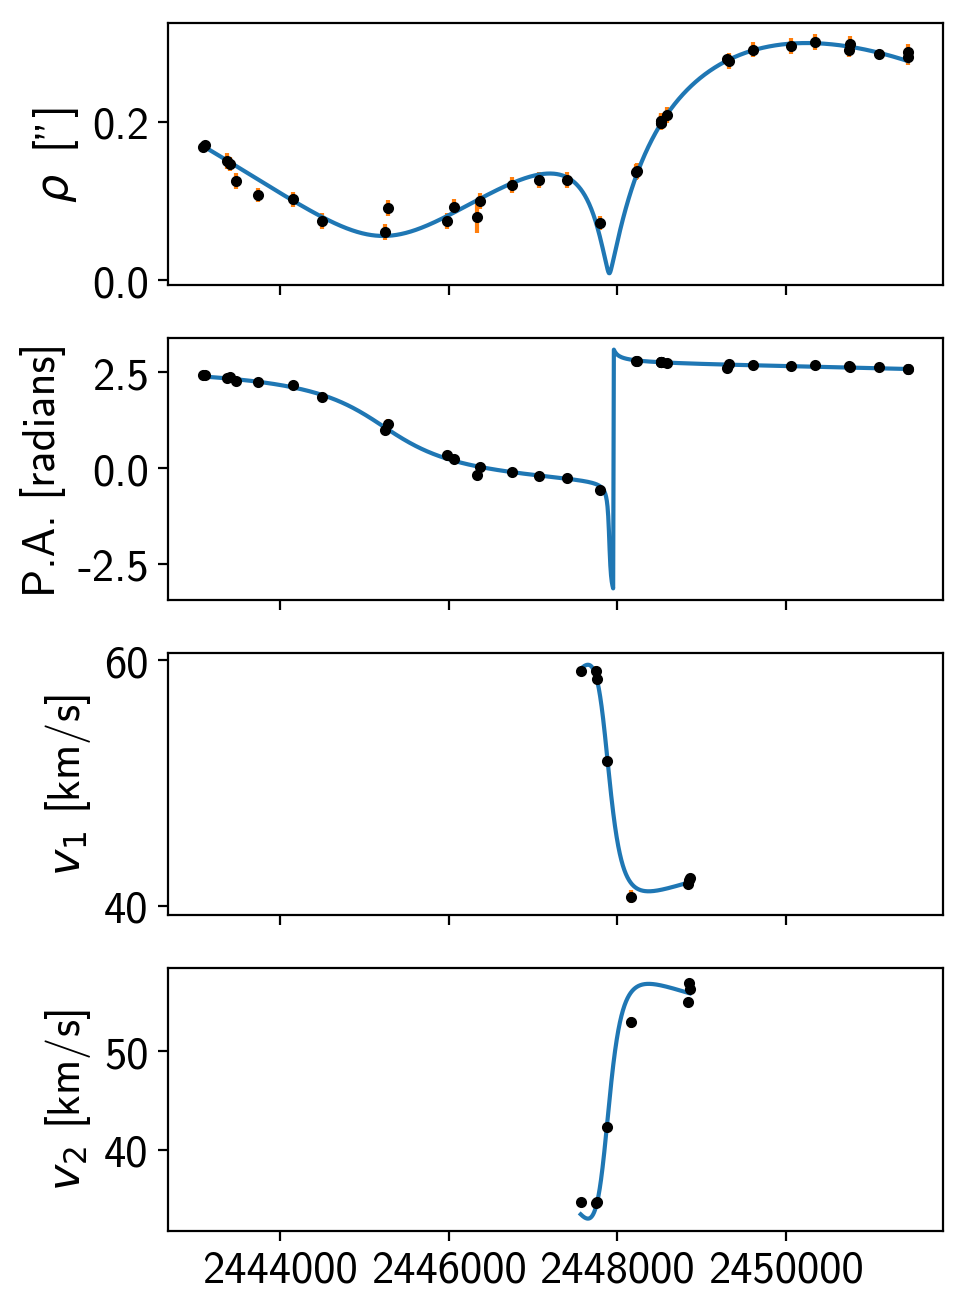

In [14]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [15]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:07, 100.20draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:11, 66.45draws/s] 

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:14, 53.84draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:16, 47.51draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:17, 43.92draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:18, 41.66draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:19, 40.27draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:19, 39.33draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:19, 38.72draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:20, 37.59draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:20, 37.52draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:20, 37.49draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:19, 37.45draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:19, 37.44draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:19, 37.04draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:19, 36.88draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:19, 36.72draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:19, 36.36draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:02<00:20, 36.12draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:20, 34.82draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:20, 35.02draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:20, 34.60draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:02<00:19, 37.05draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:02<00:19, 36.60draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:02<00:19, 36.28draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:02<00:19, 35.88draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:03<00:19, 35.81draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:03<00:19, 35.75draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:03<00:19, 35.70draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:03<00:19, 35.55draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:03<00:18, 35.57draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:03<00:18, 35.57draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:03<00:19, 34.11draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:03<00:18, 34.89draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:03<00:18, 35.46draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:04<00:18, 35.88draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:04<00:17, 36.16draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:04<00:17, 36.20draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:04<00:17, 36.08draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:04<00:17, 36.29draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:04<00:17, 36.36draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:04<00:17, 36.46draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:04<00:17, 36.58draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:04<00:16, 36.63draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:05<00:16, 36.58draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:05<00:16, 36.83draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:05<00:16, 37.04draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:05<00:16, 37.21draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:05<00:16, 36.98draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:05<00:16, 37.12draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:05<00:15, 37.22draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:05<00:15, 37.33draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:05<00:15, 37.38draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:05<00:15, 37.44draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:06<00:15, 37.47draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:06<00:15, 37.23draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:06<00:15, 36.85draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:06<00:15, 36.46draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:06<00:15, 36.18draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:06<00:15, 36.00draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:06<00:15, 35.89draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:06<00:15, 35.66draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:06<00:15, 35.65draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:07<00:15, 35.62draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:07<00:15, 35.63draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:07<00:14, 35.63draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:07<00:14, 35.61draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:07<00:14, 35.49draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:07<00:14, 35.87draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:07<00:14, 36.16draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:07<00:14, 36.37draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:07<00:13, 36.50draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:08<00:13, 36.61draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:08<00:14, 34.91draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:08<00:14, 35.46draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:08<00:13, 35.88draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:08<00:13, 36.18draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:08<00:13, 36.40draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:08<00:13, 36.55draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:08<00:13, 36.66draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:08<00:12, 36.59draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:09<00:12, 36.78draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:09<00:12, 37.05draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:09<00:12, 37.16draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:09<00:12, 37.29draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:09<00:12, 36.96draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:09<00:12, 36.47draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:09<00:12, 36.61draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:09<00:12, 35.95draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:09<00:12, 36.23draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:10<00:11, 36.44draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:10<00:11, 37.59draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:10<00:11, 37.18draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:10<00:11, 37.09draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:10<00:11, 37.26draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:10<00:11, 37.37draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:10<00:10, 37.21draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:10<00:10, 37.24draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:10<00:10, 37.35draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:11<00:10, 37.26draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:11<00:10, 37.38draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:11<00:10, 37.20draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:11<00:10, 36.90draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:11<00:10, 36.54draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:11<00:10, 36.27draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:11<00:10, 36.11draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:11<00:10, 35.99draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:11<00:10, 35.91draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:12<00:10, 35.94draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:12<00:10, 35.54draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:12<00:09, 35.56draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:12<00:09, 35.76draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:12<00:09, 36.11draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:12<00:09, 36.37draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:12<00:09, 36.55draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:12<00:09, 36.68draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:12<00:08, 36.75draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:13<00:08, 36.83draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:13<00:08, 36.87draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:13<00:08, 36.90draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:13<00:08, 36.93draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:13<00:08, 36.94draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:13<00:08, 36.94draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:13<00:08, 36.65draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:13<00:08, 36.74draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:13<00:07, 36.82draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:14<00:07, 36.86draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:14<00:07, 36.91draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:14<00:07, 36.92draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:14<00:07, 36.71draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:14<00:07, 36.71draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:14<00:07, 36.00draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:14<00:07, 34.95draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:14<00:07, 35.73draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:14<00:07, 36.32draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:14<00:06, 36.73draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:15<00:06, 37.00draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:15<00:06, 36.95draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:15<00:06, 36.74draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:15<00:06, 36.51draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:15<00:06, 36.33draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:15<00:06, 35.67draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:15<00:06, 35.76draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:15<00:06, 35.77draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:15<00:06, 35.82draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:16<00:05, 35.84draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:16<00:05, 35.86draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:16<00:05, 35.88draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:16<00:05, 35.90draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:16<00:05, 35.89draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:16<00:05, 35.90draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:16<00:05, 35.90draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:16<00:05, 35.90draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:16<00:05, 35.88draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:17<00:04, 35.74draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:17<00:04, 35.77draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:17<00:04, 35.78draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:17<00:04, 35.81draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:17<00:04, 36.23draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:17<00:04, 36.67draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:17<00:04, 36.96draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:17<00:04, 37.16draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:17<00:03, 37.32draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:18<00:03, 37.43draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:18<00:03, 37.51draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:18<00:03, 37.55draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:18<00:03, 37.57draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:18<00:03, 37.63draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:18<00:03, 37.66draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:18<00:03, 37.67draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:18<00:02, 37.70draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:18<00:02, 37.60draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:19<00:02, 37.42draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:19<00:02, 36.45draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:19<00:02, 36.41draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:19<00:02, 36.37draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:19<00:02, 36.34draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:19<00:02, 36.32draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:19<00:02, 36.33draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:19<00:02, 36.34draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:19<00:02, 36.37draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:20<00:01, 36.36draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:20<00:01, 36.22draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:20<00:01, 36.28draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:20<00:01, 36.34draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:20<00:01, 38.69draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:20<00:01, 37.99draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:20<00:01, 37.50draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:20<00:01, 37.18draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:20<00:00, 36.95draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:21<00:00, 36.81draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:21<00:00, 36.66draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:21<00:00, 33.07draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:21<00:00, 29.59draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:21<00:00, 30.49draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:21<00:00, 25.40draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:21<00:00, 25.98draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:22<00:00, 19.85draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:22<00:00, 18.00draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:23<00:00,  8.32draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:03, 117.17draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 69.19draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:07, 53.89draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:07, 50.68draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:08, 44.95draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:08, 41.65draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:08, 41.88draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:00<00:08, 42.66draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:01<00:08, 41.64draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:01<00:08, 41.11draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:01<00:07, 43.23draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:01<00:07, 43.35draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:01<00:07, 43.35draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:01<00:07, 43.30draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:07, 43.99draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:01<00:07, 44.18draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:01<00:07, 44.36draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:02<00:06, 44.49draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:02<00:06, 43.65draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:02<00:06, 43.44draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:02<00:06, 46.11draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:02<00:07, 40.72draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:02<00:06, 41.74draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:02<00:06, 42.15draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:02<00:07, 36.69draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:03<00:06, 38.78draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:03<00:06, 40.41draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:03<00:06, 39.12draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:03<00:06, 40.69draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:03<00:05, 41.83draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:03<00:05, 42.60draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:03<00:05, 42.90draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:03<00:05, 39.78draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:04<00:05, 40.54draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:04<00:05, 39.59draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:05, 41.49draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:04<00:05, 41.01draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:04<00:05, 37.81draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:04<00:05, 38.83draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:04<00:05, 37.94draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:04<00:05, 37.06draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:05<00:04, 38.97draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:05<00:04, 42.56draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:05<00:04, 42.79draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:05<00:04, 42.25draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:05<00:03, 43.95draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:05<00:03, 43.94draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:05<00:03, 43.43draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:05<00:03, 43.68draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:05<00:03, 43.19draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:06<00:03, 39.23draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:06<00:03, 40.40draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:06<00:03, 41.28draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:06<00:03, 38.22draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:06<00:03, 40.22draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:06<00:02, 41.33draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:06<00:02, 41.86draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:06<00:02, 41.43draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:07<00:02, 42.31draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:07<00:02, 42.31draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:07<00:02, 42.61draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:07<00:02, 41.42draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:07<00:02, 39.81draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:07<00:01, 41.33draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:07<00:01, 41.87draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:08<00:01, 36.14draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:08<00:01, 39.35draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:08<00:01, 40.35draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:08<00:01, 41.57draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:08<00:01, 40.71draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:08<00:01, 41.37draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:08<00:00, 44.50draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:08<00:00, 43.84draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:08<00:00, 44.17draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:09<00:00, 43.67draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:09<00:00, 44.08draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:09<00:00, 44.07draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:09<00:00, 38.08draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:09<00:00, 28.07draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 40.92draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:05, 149.87draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:04, 168.87draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:00<00:03, 195.54draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:00<00:03, 224.49draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:00<00:02, 234.96draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:00<00:02, 259.49draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:00<00:02, 280.94draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:00<00:01, 306.33draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:00<00:01, 296.90draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:01<00:01, 302.15draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:01<00:01, 325.22draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:01<00:01, 344.11draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:01<00:01, 351.00draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:01<00:00, 357.71draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:01<00:00, 356.00draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:01<00:00, 362.77draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:01<00:00, 363.77draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:01<00:00, 376.49draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:01<00:00, 371.68draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:02<00:00, 336.56draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:02<00:00, 294.62draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:02<00:00, 258.56draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:02<00:00, 216.21draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 291.40draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<00:08, 196.63draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:07, 207.58draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:00<00:07, 216.92draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:00<00:08, 174.58draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:00<00:12, 125.27draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:00<00:12, 123.50draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:00<00:12, 119.80draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:00<00:10, 133.88draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:01<00:09, 148.97draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:01<00:08, 162.98draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:01<00:07, 179.48draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:01<00:06, 200.14draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:01<00:06, 198.55draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:01<00:06, 201.57draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:01<00:06, 213.11draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:01<00:05, 228.96draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:01<00:05, 218.41draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [00:02<00:05, 213.59draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:02<00:05, 219.68draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:02<00:05, 221.84draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:02<00:05, 213.12draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:02<00:04, 227.39draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:02<00:04, 227.88draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:02<00:04, 222.87draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:02<00:04, 227.37draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:02<00:04, 230.10draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:02<00:04, 229.28draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:03<00:04, 230.62draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:03<00:04, 238.03draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:03<00:04, 222.32draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [00:03<00:04, 222.09draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [00:03<00:03, 233.33draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:03<00:03, 245.06draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [00:03<00:03, 254.42draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [00:03<00:03, 252.31draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:03<00:03, 250.17draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [00:04<00:02, 259.45draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [00:04<00:02, 266.66draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [00:04<00:02, 259.36draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [00:04<00:02, 241.51draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [00:04<00:02, 245.59draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [00:04<00:02, 251.55draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [00:04<00:02, 260.26draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [00:04<00:02, 268.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [00:04<00:02, 255.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [00:04<00:01, 254.80draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [00:05<00:01, 249.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [00:05<00:01, 244.20draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [00:05<00:01, 252.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [00:05<00:01, 248.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [00:05<00:01, 246.17draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [00:05<00:01, 236.98draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [00:05<00:01, 245.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [00:05<00:01, 237.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:05<00:01, 241.33draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [00:06<00:00, 241.69draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [00:06<00:00, 229.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [00:06<00:00, 225.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [00:06<00:00, 229.89draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [00:06<00:00, 237.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [00:06<00:00, 248.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [00:06<00:00, 243.61draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [00:06<00:00, 228.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [00:06<00:00, 198.23draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [00:07<00:00, 157.45draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:07<00:00, 214.11draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:00<00:21, 147.53draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:00<00:21, 147.33draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:00<00:23, 135.27draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:00<00:22, 142.57draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:00<00:20, 155.09draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:00<00:18, 171.84draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:00<00:16, 188.71draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:00<00:15, 192.16draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:00<00:15, 198.50draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:01<00:14, 208.63draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:01<00:14, 209.94draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:01<00:14, 209.31draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:01<00:14, 209.55draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:01<00:13, 216.94draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:01<00:13, 221.77draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:01<00:12, 226.27draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:01<00:13, 216.75draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:01<00:14, 193.80draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [00:02<00:13, 200.50draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:02<00:13, 208.09draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:02<00:12, 213.19draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:02<00:12, 212.69draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [00:02<00:13, 204.02draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [00:02<00:13, 205.02draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:02<00:12, 208.27draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [00:02<00:11, 220.92draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [00:02<00:11, 226.92draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:02<00:11, 219.21draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:03<00:11, 226.69draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:03<00:10, 232.68draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:03<00:11, 224.19draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:03<00:11, 224.33draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [00:03<00:10, 236.20draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [00:03<00:09, 248.63draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [00:03<00:09, 254.39draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:03<00:10, 238.54draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [00:03<00:10, 225.34draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:04<00:10, 227.49draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [00:04<00:09, 237.09draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [00:04<00:09, 249.73draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [00:04<00:09, 249.81draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [00:04<00:08, 259.22draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [00:04<00:08, 246.38draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [00:04<00:08, 242.13draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [00:04<00:08, 240.69draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [00:04<00:08, 255.66draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [00:05<00:07, 264.31draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [00:05<00:07, 273.37draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [00:05<00:07, 275.89draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [00:05<00:07, 268.52draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [00:05<00:07, 252.03draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [00:05<00:08, 238.67draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [00:05<00:07, 241.73draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [00:05<00:07, 248.78draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [00:05<00:07, 255.06draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [00:05<00:06, 265.31draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [00:06<00:06, 265.83draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [00:06<00:06, 271.42draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [00:06<00:06, 263.25draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [00:06<00:06, 256.73draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [00:06<00:06, 262.99draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [00:06<00:06, 259.97draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [00:06<00:06, 260.55draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [00:06<00:06, 255.16draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [00:06<00:06, 254.87draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [00:07<00:05, 262.55draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [00:07<00:05, 265.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [00:07<00:05, 271.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [00:07<00:05, 269.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [00:07<00:05, 267.66draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [00:07<00:05, 241.52draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [00:07<00:05, 239.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [00:07<00:05, 244.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [00:07<00:05, 243.30draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [00:08<00:05, 247.74draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [00:08<00:05, 254.67draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [00:08<00:04, 261.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [00:08<00:04, 262.02draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [00:08<00:04, 264.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [00:08<00:04, 265.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [00:08<00:04, 263.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [00:08<00:04, 255.89draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [00:08<00:04, 267.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [00:08<00:04, 260.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [00:09<00:03, 262.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [00:09<00:03, 267.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [00:09<00:03, 271.54draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [00:09<00:03, 267.01draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:09<00:03, 248.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [00:09<00:03, 242.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [00:09<00:03, 246.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [00:09<00:03, 251.61draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [00:09<00:03, 253.07draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [00:10<00:03, 254.60draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [00:10<00:03, 256.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [00:10<00:02, 267.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [00:10<00:02, 270.68draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [00:10<00:02, 279.57draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [00:10<00:02, 284.26draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [00:10<00:02, 272.00draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [00:10<00:02, 263.19draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [00:10<00:02, 261.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [00:10<00:01, 275.89draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [00:11<00:01, 282.26draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [00:11<00:01, 277.38draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [00:11<00:01, 275.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [00:11<00:01, 268.11draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [00:11<00:01, 260.54draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [00:11<00:01, 259.98draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [00:11<00:01, 255.22draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [00:11<00:01, 253.12draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [00:11<00:01, 248.58draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [00:12<00:01, 248.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [00:12<00:00, 247.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [00:12<00:00, 252.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [00:12<00:00, 254.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [00:12<00:00, 257.87draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [00:12<00:00, 261.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [00:12<00:00, 235.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [00:12<00:00, 223.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [00:12<00:00, 222.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [00:13<00:00, 217.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [00:13<00:00, 171.55draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:13<00:00, 239.86draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 20/9208 [00:00<00:47, 195.44draws/s]

Sampling 4 chains:   0%|          | 40/9208 [00:00<00:46, 195.68draws/s]

Sampling 4 chains:   1%|          | 59/9208 [00:00<00:47, 193.14draws/s]

Sampling 4 chains:   1%|          | 72/9208 [00:00<00:55, 164.24draws/s]

Sampling 4 chains:   1%|          | 91/9208 [00:00<00:54, 168.01draws/s]

Sampling 4 chains:   1%|          | 112/9208 [00:00<00:51, 176.59draws/s]

Sampling 4 chains:   1%|▏         | 133/9208 [00:00<00:50, 179.03draws/s]

Sampling 4 chains:   2%|▏         | 150/9208 [00:00<00:57, 158.16draws/s]

Sampling 4 chains:   2%|▏         | 172/9208 [00:00<00:53, 168.86draws/s]

Sampling 4 chains:   2%|▏         | 194/9208 [00:01<00:50, 179.59draws/s]

Sampling 4 chains:   2%|▏         | 220/9208 [00:01<00:45, 196.49draws/s]

Sampling 4 chains:   3%|▎         | 241/9208 [00:01<00:45, 195.90draws/s]

Sampling 4 chains:   3%|▎         | 262/9208 [00:01<00:45, 198.37draws/s]

Sampling 4 chains:   3%|▎         | 283/9208 [00:01<00:46, 191.02draws/s]

Sampling 4 chains:   3%|▎         | 303/9208 [00:01<00:47, 187.40draws/s]

Sampling 4 chains:   3%|▎         | 322/9208 [00:01<00:50, 175.04draws/s]

Sampling 4 chains:   4%|▎         | 340/9208 [00:01<00:52, 169.37draws/s]

Sampling 4 chains:   4%|▍         | 358/9208 [00:01<00:51, 171.54draws/s]

Sampling 4 chains:   4%|▍         | 379/9208 [00:02<00:49, 177.31draws/s]

Sampling 4 chains:   4%|▍         | 405/9208 [00:02<00:45, 195.46draws/s]

Sampling 4 chains:   5%|▍         | 431/9208 [00:02<00:41, 210.62draws/s]

Sampling 4 chains:   5%|▌         | 461/9208 [00:02<00:38, 229.87draws/s]

Sampling 4 chains:   5%|▌         | 489/9208 [00:02<00:37, 233.04draws/s]

Sampling 4 chains:   6%|▌         | 514/9208 [00:02<00:36, 235.78draws/s]

Sampling 4 chains:   6%|▌         | 542/9208 [00:02<00:35, 246.50draws/s]

Sampling 4 chains:   6%|▌         | 569/9208 [00:02<00:34, 250.90draws/s]

Sampling 4 chains:   6%|▋         | 595/9208 [00:02<00:34, 251.01draws/s]

Sampling 4 chains:   7%|▋         | 621/9208 [00:03<00:33, 253.33draws/s]

Sampling 4 chains:   7%|▋         | 647/9208 [00:03<00:33, 252.74draws/s]

Sampling 4 chains:   7%|▋         | 674/9208 [00:03<00:33, 256.40draws/s]

Sampling 4 chains:   8%|▊         | 702/9208 [00:03<00:32, 261.23draws/s]

Sampling 4 chains:   8%|▊         | 732/9208 [00:03<00:31, 268.90draws/s]

Sampling 4 chains:   8%|▊         | 760/9208 [00:03<00:33, 253.52draws/s]

Sampling 4 chains:   9%|▊         | 786/9208 [00:03<00:33, 248.21draws/s]

Sampling 4 chains:   9%|▉         | 812/9208 [00:03<00:34, 242.66draws/s]

Sampling 4 chains:   9%|▉         | 837/9208 [00:03<00:34, 241.40draws/s]

Sampling 4 chains:   9%|▉         | 866/9208 [00:03<00:33, 248.18draws/s]

Sampling 4 chains:  10%|▉         | 897/9208 [00:04<00:31, 263.27draws/s]

Sampling 4 chains:  10%|█         | 924/9208 [00:04<00:32, 257.20draws/s]

Sampling 4 chains:  10%|█         | 950/9208 [00:04<00:32, 254.86draws/s]

Sampling 4 chains:  11%|█         | 976/9208 [00:04<00:32, 252.05draws/s]

Sampling 4 chains:  11%|█         | 1004/9208 [00:04<00:31, 258.81draws/s]

Sampling 4 chains:  11%|█         | 1034/9208 [00:04<00:30, 268.92draws/s]

Sampling 4 chains:  12%|█▏        | 1065/9208 [00:04<00:29, 278.89draws/s]

Sampling 4 chains:  12%|█▏        | 1094/9208 [00:04<00:29, 278.60draws/s]

Sampling 4 chains:  12%|█▏        | 1123/9208 [00:04<00:29, 278.44draws/s]

Sampling 4 chains:  12%|█▎        | 1151/9208 [00:05<00:29, 273.67draws/s]

Sampling 4 chains:  13%|█▎        | 1179/9208 [00:05<00:30, 259.33draws/s]

Sampling 4 chains:  13%|█▎        | 1206/9208 [00:05<00:31, 254.44draws/s]

Sampling 4 chains:  13%|█▎        | 1232/9208 [00:05<00:33, 241.07draws/s]

Sampling 4 chains:  14%|█▎        | 1257/9208 [00:05<00:33, 240.83draws/s]

Sampling 4 chains:  14%|█▍        | 1283/9208 [00:05<00:32, 241.48draws/s]

Sampling 4 chains:  14%|█▍        | 1309/9208 [00:05<00:32, 241.18draws/s]

Sampling 4 chains:  14%|█▍        | 1334/9208 [00:05<00:32, 243.50draws/s]

Sampling 4 chains:  15%|█▍        | 1361/9208 [00:05<00:31, 248.33draws/s]

Sampling 4 chains:  15%|█▌        | 1390/9208 [00:06<00:30, 256.01draws/s]

Sampling 4 chains:  15%|█▌        | 1417/9208 [00:06<00:30, 258.98draws/s]

Sampling 4 chains:  16%|█▌        | 1446/9208 [00:06<00:29, 266.18draws/s]

Sampling 4 chains:  16%|█▌        | 1475/9208 [00:06<00:28, 271.50draws/s]

Sampling 4 chains:  16%|█▋        | 1503/9208 [00:06<00:28, 272.86draws/s]

Sampling 4 chains:  17%|█▋        | 1531/9208 [00:06<00:27, 274.36draws/s]

Sampling 4 chains:  17%|█▋        | 1560/9208 [00:06<00:27, 278.62draws/s]

Sampling 4 chains:  17%|█▋        | 1597/9208 [00:06<00:25, 296.79draws/s]

Sampling 4 chains:  18%|█▊        | 1628/9208 [00:06<00:26, 290.29draws/s]

Sampling 4 chains:  18%|█▊        | 1658/9208 [00:06<00:25, 291.16draws/s]

Sampling 4 chains:  18%|█▊        | 1688/9208 [00:07<00:27, 273.79draws/s]

Sampling 4 chains:  19%|█▊        | 1716/9208 [00:07<00:27, 269.14draws/s]

Sampling 4 chains:  19%|█▉        | 1744/9208 [00:07<00:28, 266.28draws/s]

Sampling 4 chains:  19%|█▉        | 1772/9208 [00:07<00:27, 268.60draws/s]

Sampling 4 chains:  20%|█▉        | 1801/9208 [00:07<00:26, 274.68draws/s]

Sampling 4 chains:  20%|█▉        | 1837/9208 [00:07<00:24, 295.40draws/s]

Sampling 4 chains:  20%|██        | 1869/9208 [00:07<00:24, 300.31draws/s]

Sampling 4 chains:  21%|██        | 1900/9208 [00:07<00:25, 287.99draws/s]

Sampling 4 chains:  21%|██        | 1930/9208 [00:07<00:25, 288.01draws/s]

Sampling 4 chains:  21%|██▏       | 1963/9208 [00:08<00:24, 298.94draws/s]

Sampling 4 chains:  22%|██▏       | 1994/9208 [00:08<00:25, 285.47draws/s]

Sampling 4 chains:  22%|██▏       | 2023/9208 [00:08<00:25, 281.33draws/s]

Sampling 4 chains:  22%|██▏       | 2052/9208 [00:08<00:26, 273.28draws/s]

Sampling 4 chains:  23%|██▎       | 2080/9208 [00:08<00:27, 260.19draws/s]

Sampling 4 chains:  23%|██▎       | 2108/9208 [00:08<00:27, 260.72draws/s]

Sampling 4 chains:  23%|██▎       | 2135/9208 [00:08<00:27, 258.25draws/s]

Sampling 4 chains:  23%|██▎       | 2161/9208 [00:08<00:27, 256.03draws/s]

Sampling 4 chains:  24%|██▍       | 2187/9208 [00:08<00:27, 253.14draws/s]

Sampling 4 chains:  24%|██▍       | 2213/9208 [00:08<00:27, 253.98draws/s]

Sampling 4 chains:  24%|██▍       | 2241/9208 [00:09<00:26, 259.69draws/s]

Sampling 4 chains:  25%|██▍       | 2268/9208 [00:09<00:26, 262.70draws/s]

Sampling 4 chains:  25%|██▍       | 2296/9208 [00:09<00:26, 265.43draws/s]

Sampling 4 chains:  25%|██▌       | 2323/9208 [00:09<00:26, 264.23draws/s]

Sampling 4 chains:  26%|██▌       | 2351/9208 [00:09<00:25, 266.62draws/s]

Sampling 4 chains:  26%|██▌       | 2378/9208 [00:09<00:25, 265.92draws/s]

Sampling 4 chains:  26%|██▌       | 2405/9208 [00:09<00:25, 263.94draws/s]

Sampling 4 chains:  26%|██▋       | 2432/9208 [00:09<00:26, 258.98draws/s]

Sampling 4 chains:  27%|██▋       | 2459/9208 [00:09<00:26, 258.66draws/s]

Sampling 4 chains:  27%|██▋       | 2485/9208 [00:10<00:26, 257.40draws/s]

Sampling 4 chains:  27%|██▋       | 2512/9208 [00:10<00:25, 260.20draws/s]

Sampling 4 chains:  28%|██▊       | 2541/9208 [00:10<00:25, 264.15draws/s]

Sampling 4 chains:  28%|██▊       | 2569/9208 [00:10<00:24, 268.55draws/s]

Sampling 4 chains:  28%|██▊       | 2598/9208 [00:10<00:24, 272.70draws/s]

Sampling 4 chains:  29%|██▊       | 2626/9208 [00:10<00:24, 273.62draws/s]

Sampling 4 chains:  29%|██▉       | 2655/9208 [00:10<00:23, 275.45draws/s]

Sampling 4 chains:  29%|██▉       | 2683/9208 [00:10<00:25, 260.21draws/s]

Sampling 4 chains:  29%|██▉       | 2710/9208 [00:10<00:25, 259.86draws/s]

Sampling 4 chains:  30%|██▉       | 2738/9208 [00:10<00:24, 264.03draws/s]

Sampling 4 chains:  30%|███       | 2765/9208 [00:11<00:24, 261.93draws/s]

Sampling 4 chains:  30%|███       | 2792/9208 [00:11<00:24, 264.01draws/s]

Sampling 4 chains:  31%|███       | 2819/9208 [00:11<00:24, 264.38draws/s]

Sampling 4 chains:  31%|███       | 2849/9208 [00:11<00:23, 273.45draws/s]

Sampling 4 chains:  31%|███       | 2877/9208 [00:11<00:23, 267.51draws/s]

Sampling 4 chains:  32%|███▏      | 2904/9208 [00:11<00:23, 264.16draws/s]

Sampling 4 chains:  32%|███▏      | 2931/9208 [00:11<00:23, 263.84draws/s]

Sampling 4 chains:  32%|███▏      | 2958/9208 [00:11<00:23, 265.02draws/s]

Sampling 4 chains:  32%|███▏      | 2985/9208 [00:11<00:23, 260.51draws/s]

Sampling 4 chains:  33%|███▎      | 3014/9208 [00:12<00:23, 264.47draws/s]

Sampling 4 chains:  33%|███▎      | 3041/9208 [00:12<00:23, 263.32draws/s]

Sampling 4 chains:  33%|███▎      | 3068/9208 [00:12<00:23, 259.19draws/s]

Sampling 4 chains:  34%|███▎      | 3094/9208 [00:12<00:24, 246.86draws/s]

Sampling 4 chains:  34%|███▍      | 3123/9208 [00:12<00:23, 258.36draws/s]

Sampling 4 chains:  34%|███▍      | 3152/9208 [00:12<00:22, 265.29draws/s]

Sampling 4 chains:  35%|███▍      | 3180/9208 [00:12<00:22, 268.49draws/s]

Sampling 4 chains:  35%|███▍      | 3208/9208 [00:12<00:23, 257.59draws/s]

Sampling 4 chains:  35%|███▌      | 3234/9208 [00:12<00:23, 251.66draws/s]

Sampling 4 chains:  35%|███▌      | 3260/9208 [00:12<00:23, 250.88draws/s]

Sampling 4 chains:  36%|███▌      | 3286/9208 [00:13<00:23, 253.43draws/s]

Sampling 4 chains:  36%|███▌      | 3314/9208 [00:13<00:22, 259.09draws/s]

Sampling 4 chains:  36%|███▋      | 3344/9208 [00:13<00:21, 269.76draws/s]

Sampling 4 chains:  37%|███▋      | 3375/9208 [00:13<00:20, 279.16draws/s]

Sampling 4 chains:  37%|███▋      | 3404/9208 [00:13<00:20, 280.05draws/s]

Sampling 4 chains:  37%|███▋      | 3434/9208 [00:13<00:20, 284.19draws/s]

Sampling 4 chains:  38%|███▊      | 3463/9208 [00:13<00:20, 284.74draws/s]

Sampling 4 chains:  38%|███▊      | 3492/9208 [00:13<00:20, 285.20draws/s]

Sampling 4 chains:  38%|███▊      | 3523/9208 [00:13<00:19, 290.15draws/s]

Sampling 4 chains:  39%|███▊      | 3553/9208 [00:13<00:19, 292.38draws/s]

Sampling 4 chains:  39%|███▉      | 3583/9208 [00:14<00:19, 288.40draws/s]

Sampling 4 chains:  39%|███▉      | 3613/9208 [00:14<00:19, 290.80draws/s]

Sampling 4 chains:  40%|███▉      | 3643/9208 [00:14<00:20, 277.39draws/s]

Sampling 4 chains:  40%|███▉      | 3671/9208 [00:14<00:20, 273.57draws/s]

Sampling 4 chains:  40%|████      | 3699/9208 [00:14<00:20, 269.04draws/s]

Sampling 4 chains:  40%|████      | 3728/9208 [00:14<00:20, 270.87draws/s]

Sampling 4 chains:  41%|████      | 3758/9208 [00:14<00:19, 275.26draws/s]

Sampling 4 chains:  41%|████      | 3786/9208 [00:14<00:20, 266.71draws/s]

Sampling 4 chains:  41%|████▏     | 3813/9208 [00:14<00:21, 256.43draws/s]

Sampling 4 chains:  42%|████▏     | 3841/9208 [00:15<00:20, 261.86draws/s]

Sampling 4 chains:  42%|████▏     | 3869/9208 [00:15<00:20, 264.38draws/s]

Sampling 4 chains:  42%|████▏     | 3898/9208 [00:15<00:19, 269.91draws/s]

Sampling 4 chains:  43%|████▎     | 3927/9208 [00:15<00:19, 274.32draws/s]

Sampling 4 chains:  43%|████▎     | 3958/9208 [00:15<00:18, 283.38draws/s]

Sampling 4 chains:  43%|████▎     | 3987/9208 [00:15<00:18, 274.99draws/s]

Sampling 4 chains:  44%|████▎     | 4015/9208 [00:15<00:18, 273.35draws/s]

Sampling 4 chains:  44%|████▍     | 4043/9208 [00:15<00:18, 273.08draws/s]

Sampling 4 chains:  44%|████▍     | 4071/9208 [00:15<00:18, 270.82draws/s]

Sampling 4 chains:  45%|████▍     | 4102/9208 [00:16<00:18, 279.62draws/s]

Sampling 4 chains:  45%|████▍     | 4133/9208 [00:16<00:17, 286.41draws/s]

Sampling 4 chains:  45%|████▌     | 4162/9208 [00:16<00:17, 280.54draws/s]

Sampling 4 chains:  46%|████▌     | 4191/9208 [00:16<00:18, 276.90draws/s]

Sampling 4 chains:  46%|████▌     | 4219/9208 [00:16<00:18, 273.45draws/s]

Sampling 4 chains:  46%|████▌     | 4247/9208 [00:16<00:18, 270.72draws/s]

Sampling 4 chains:  46%|████▋     | 4275/9208 [00:16<00:18, 268.27draws/s]

Sampling 4 chains:  47%|████▋     | 4303/9208 [00:16<00:18, 270.39draws/s]

Sampling 4 chains:  47%|████▋     | 4332/9208 [00:16<00:17, 274.57draws/s]

Sampling 4 chains:  47%|████▋     | 4363/9208 [00:16<00:17, 284.11draws/s]

Sampling 4 chains:  48%|████▊     | 4392/9208 [00:17<00:17, 283.29draws/s]

Sampling 4 chains:  48%|████▊     | 4421/9208 [00:17<00:17, 277.72draws/s]

Sampling 4 chains:  48%|████▊     | 4449/9208 [00:17<00:17, 272.06draws/s]

Sampling 4 chains:  49%|████▊     | 4477/9208 [00:17<00:17, 272.17draws/s]

Sampling 4 chains:  49%|████▉     | 4505/9208 [00:17<00:18, 257.62draws/s]

Sampling 4 chains:  49%|████▉     | 4534/9208 [00:17<00:17, 262.52draws/s]

Sampling 4 chains:  50%|████▉     | 4561/9208 [00:17<00:17, 263.35draws/s]

Sampling 4 chains:  50%|████▉     | 4588/9208 [00:17<00:17, 263.37draws/s]

Sampling 4 chains:  50%|█████     | 4615/9208 [00:17<00:17, 263.32draws/s]

Sampling 4 chains:  50%|█████     | 4645/9208 [00:18<00:16, 272.13draws/s]

Sampling 4 chains:  51%|█████     | 4675/9208 [00:18<00:16, 276.78draws/s]

Sampling 4 chains:  51%|█████     | 4705/9208 [00:18<00:15, 282.57draws/s]

Sampling 4 chains:  51%|█████▏    | 4734/9208 [00:18<00:16, 279.36draws/s]

Sampling 4 chains:  52%|█████▏    | 4763/9208 [00:18<00:16, 273.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4791/9208 [00:18<00:16, 270.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4819/9208 [00:18<00:16, 268.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4847/9208 [00:18<00:16, 269.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4874/9208 [00:18<00:16, 264.02draws/s]

Sampling 4 chains:  53%|█████▎    | 4901/9208 [00:18<00:16, 259.80draws/s]

Sampling 4 chains:  54%|█████▎    | 4930/9208 [00:19<00:16, 263.18draws/s]

Sampling 4 chains:  54%|█████▍    | 4959/9208 [00:19<00:15, 268.44draws/s]

Sampling 4 chains:  54%|█████▍    | 4986/9208 [00:19<00:15, 267.61draws/s]

Sampling 4 chains:  54%|█████▍    | 5013/9208 [00:19<00:15, 266.19draws/s]

Sampling 4 chains:  55%|█████▍    | 5043/9208 [00:19<00:15, 273.87draws/s]

Sampling 4 chains:  55%|█████▌    | 5071/9208 [00:19<00:15, 274.20draws/s]

Sampling 4 chains:  55%|█████▌    | 5099/9208 [00:19<00:15, 269.27draws/s]

Sampling 4 chains:  56%|█████▌    | 5126/9208 [00:19<00:15, 266.44draws/s]

Sampling 4 chains:  56%|█████▌    | 5153/9208 [00:19<00:15, 265.58draws/s]

Sampling 4 chains:  56%|█████▋    | 5180/9208 [00:19<00:15, 261.34draws/s]

Sampling 4 chains:  57%|█████▋    | 5208/9208 [00:20<00:15, 266.16draws/s]

Sampling 4 chains:  57%|█████▋    | 5235/9208 [00:20<00:15, 262.67draws/s]

Sampling 4 chains:  57%|█████▋    | 5262/9208 [00:20<00:15, 262.04draws/s]

Sampling 4 chains:  57%|█████▋    | 5289/9208 [00:20<00:14, 264.29draws/s]

Sampling 4 chains:  58%|█████▊    | 5317/9208 [00:20<00:14, 268.55draws/s]

Sampling 4 chains:  58%|█████▊    | 5346/9208 [00:20<00:14, 274.13draws/s]

Sampling 4 chains:  58%|█████▊    | 5375/9208 [00:20<00:13, 276.74draws/s]

Sampling 4 chains:  59%|█████▊    | 5404/9208 [00:20<00:13, 280.43draws/s]

Sampling 4 chains:  59%|█████▉    | 5433/9208 [00:20<00:13, 274.81draws/s]

Sampling 4 chains:  59%|█████▉    | 5461/9208 [00:21<00:13, 267.73draws/s]

Sampling 4 chains:  60%|█████▉    | 5488/9208 [00:21<00:13, 266.23draws/s]

Sampling 4 chains:  60%|█████▉    | 5515/9208 [00:21<00:13, 264.26draws/s]

Sampling 4 chains:  60%|██████    | 5543/9208 [00:21<00:13, 267.18draws/s]

Sampling 4 chains:  61%|██████    | 5571/9208 [00:21<00:13, 270.09draws/s]

Sampling 4 chains:  61%|██████    | 5599/9208 [00:21<00:13, 271.71draws/s]

Sampling 4 chains:  61%|██████    | 5627/9208 [00:21<00:13, 272.89draws/s]

Sampling 4 chains:  61%|██████▏   | 5656/9208 [00:21<00:12, 276.36draws/s]

Sampling 4 chains:  62%|██████▏   | 5684/9208 [00:21<00:12, 273.72draws/s]

Sampling 4 chains:  62%|██████▏   | 5712/9208 [00:21<00:12, 273.57draws/s]

Sampling 4 chains:  62%|██████▏   | 5741/9208 [00:22<00:12, 276.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5769/9208 [00:22<00:13, 260.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5796/9208 [00:22<00:13, 258.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5823/9208 [00:22<00:12, 261.34draws/s]

Sampling 4 chains:  64%|██████▎   | 5850/9208 [00:22<00:12, 261.50draws/s]

Sampling 4 chains:  64%|██████▍   | 5877/9208 [00:22<00:12, 259.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5904/9208 [00:22<00:12, 258.51draws/s]

Sampling 4 chains:  64%|██████▍   | 5930/9208 [00:22<00:12, 253.25draws/s]

Sampling 4 chains:  65%|██████▍   | 5958/9208 [00:22<00:12, 260.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5985/9208 [00:23<00:12, 261.91draws/s]

Sampling 4 chains:  65%|██████▌   | 6012/9208 [00:23<00:12, 260.44draws/s]

Sampling 4 chains:  66%|██████▌   | 6042/9208 [00:23<00:11, 270.66draws/s]

Sampling 4 chains:  66%|██████▌   | 6070/9208 [00:23<00:11, 273.15draws/s]

Sampling 4 chains:  66%|██████▌   | 6098/9208 [00:23<00:11, 274.37draws/s]

Sampling 4 chains:  67%|██████▋   | 6126/9208 [00:23<00:11, 270.03draws/s]

Sampling 4 chains:  67%|██████▋   | 6154/9208 [00:23<00:11, 265.98draws/s]

Sampling 4 chains:  67%|██████▋   | 6182/9208 [00:23<00:11, 268.09draws/s]

Sampling 4 chains:  67%|██████▋   | 6209/9208 [00:23<00:11, 268.20draws/s]

Sampling 4 chains:  68%|██████▊   | 6236/9208 [00:23<00:11, 268.63draws/s]

Sampling 4 chains:  68%|██████▊   | 6263/9208 [00:24<00:11, 266.86draws/s]

Sampling 4 chains:  68%|██████▊   | 6290/9208 [00:24<00:10, 266.88draws/s]

Sampling 4 chains:  69%|██████▊   | 6317/9208 [00:24<00:10, 267.37draws/s]

Sampling 4 chains:  69%|██████▉   | 6346/9208 [00:24<00:10, 270.11draws/s]

Sampling 4 chains:  69%|██████▉   | 6376/9208 [00:24<00:10, 276.84draws/s]

Sampling 4 chains:  70%|██████▉   | 6404/9208 [00:24<00:10, 271.09draws/s]

Sampling 4 chains:  70%|██████▉   | 6432/9208 [00:24<00:10, 272.72draws/s]

Sampling 4 chains:  70%|███████   | 6461/9208 [00:24<00:09, 274.91draws/s]

Sampling 4 chains:  70%|███████   | 6490/9208 [00:24<00:09, 273.87draws/s]

Sampling 4 chains:  71%|███████   | 6519/9208 [00:24<00:09, 275.35draws/s]

Sampling 4 chains:  71%|███████   | 6547/9208 [00:25<00:09, 275.53draws/s]

Sampling 4 chains:  71%|███████▏  | 6575/9208 [00:25<00:09, 269.24draws/s]

Sampling 4 chains:  72%|███████▏  | 6603/9208 [00:25<00:09, 270.26draws/s]

Sampling 4 chains:  72%|███████▏  | 6631/9208 [00:25<00:09, 269.19draws/s]

Sampling 4 chains:  72%|███████▏  | 6659/9208 [00:25<00:09, 272.27draws/s]

Sampling 4 chains:  73%|███████▎  | 6687/9208 [00:25<00:09, 265.07draws/s]

Sampling 4 chains:  73%|███████▎  | 6714/9208 [00:25<00:09, 261.31draws/s]

Sampling 4 chains:  73%|███████▎  | 6741/9208 [00:25<00:09, 261.13draws/s]

Sampling 4 chains:  74%|███████▎  | 6768/9208 [00:25<00:09, 263.08draws/s]

Sampling 4 chains:  74%|███████▍  | 6796/9208 [00:26<00:09, 266.60draws/s]

Sampling 4 chains:  74%|███████▍  | 6823/9208 [00:26<00:09, 264.94draws/s]

Sampling 4 chains:  74%|███████▍  | 6851/9208 [00:26<00:08, 268.06draws/s]

Sampling 4 chains:  75%|███████▍  | 6879/9208 [00:26<00:08, 270.23draws/s]

Sampling 4 chains:  75%|███████▌  | 6909/9208 [00:26<00:08, 277.53draws/s]

Sampling 4 chains:  75%|███████▌  | 6937/9208 [00:26<00:08, 277.79draws/s]

Sampling 4 chains:  76%|███████▌  | 6966/9208 [00:26<00:08, 279.69draws/s]

Sampling 4 chains:  76%|███████▌  | 6995/9208 [00:26<00:08, 265.48draws/s]

Sampling 4 chains:  76%|███████▋  | 7024/9208 [00:26<00:08, 270.62draws/s]

Sampling 4 chains:  77%|███████▋  | 7052/9208 [00:26<00:08, 264.37draws/s]

Sampling 4 chains:  77%|███████▋  | 7080/9208 [00:27<00:07, 268.32draws/s]

Sampling 4 chains:  77%|███████▋  | 7107/9208 [00:27<00:07, 267.78draws/s]

Sampling 4 chains:  77%|███████▋  | 7134/9208 [00:27<00:07, 268.13draws/s]

Sampling 4 chains:  78%|███████▊  | 7161/9208 [00:27<00:07, 258.52draws/s]

Sampling 4 chains:  78%|███████▊  | 7189/9208 [00:27<00:07, 262.52draws/s]

Sampling 4 chains:  78%|███████▊  | 7218/9208 [00:27<00:07, 269.63draws/s]

Sampling 4 chains:  79%|███████▊  | 7246/9208 [00:27<00:07, 271.48draws/s]

Sampling 4 chains:  79%|███████▉  | 7274/9208 [00:27<00:07, 268.53draws/s]

Sampling 4 chains:  79%|███████▉  | 7301/9208 [00:27<00:07, 263.49draws/s]

Sampling 4 chains:  80%|███████▉  | 7329/9208 [00:28<00:07, 265.11draws/s]

Sampling 4 chains:  80%|███████▉  | 7357/9208 [00:28<00:06, 267.17draws/s]

Sampling 4 chains:  80%|████████  | 7385/9208 [00:28<00:06, 269.93draws/s]

Sampling 4 chains:  81%|████████  | 7413/9208 [00:28<00:06, 272.37draws/s]

Sampling 4 chains:  81%|████████  | 7441/9208 [00:28<00:06, 269.31draws/s]

Sampling 4 chains:  81%|████████  | 7468/9208 [00:28<00:06, 266.94draws/s]

Sampling 4 chains:  81%|████████▏ | 7498/9208 [00:28<00:06, 275.54draws/s]

Sampling 4 chains:  82%|████████▏ | 7526/9208 [00:28<00:06, 275.43draws/s]

Sampling 4 chains:  82%|████████▏ | 7554/9208 [00:28<00:06, 269.42draws/s]

Sampling 4 chains:  82%|████████▏ | 7582/9208 [00:28<00:06, 268.98draws/s]

Sampling 4 chains:  83%|████████▎ | 7610/9208 [00:29<00:05, 271.19draws/s]

Sampling 4 chains:  83%|████████▎ | 7638/9208 [00:29<00:05, 269.61draws/s]

Sampling 4 chains:  83%|████████▎ | 7666/9208 [00:29<00:05, 272.34draws/s]

Sampling 4 chains:  84%|████████▎ | 7694/9208 [00:29<00:05, 273.09draws/s]

Sampling 4 chains:  84%|████████▍ | 7722/9208 [00:29<00:05, 274.00draws/s]

Sampling 4 chains:  84%|████████▍ | 7752/9208 [00:29<00:05, 277.51draws/s]

Sampling 4 chains:  85%|████████▍ | 7781/9208 [00:29<00:05, 279.12draws/s]

Sampling 4 chains:  85%|████████▍ | 7813/9208 [00:29<00:04, 289.23draws/s]

Sampling 4 chains:  85%|████████▌ | 7843/9208 [00:29<00:04, 288.54draws/s]

Sampling 4 chains:  85%|████████▌ | 7872/9208 [00:29<00:04, 280.09draws/s]

Sampling 4 chains:  86%|████████▌ | 7901/9208 [00:30<00:04, 279.72draws/s]

Sampling 4 chains:  86%|████████▌ | 7930/9208 [00:30<00:04, 275.68draws/s]

Sampling 4 chains:  86%|████████▋ | 7958/9208 [00:30<00:04, 271.62draws/s]

Sampling 4 chains:  87%|████████▋ | 7986/9208 [00:30<00:04, 264.93draws/s]

Sampling 4 chains:  87%|████████▋ | 8013/9208 [00:30<00:04, 265.66draws/s]

Sampling 4 chains:  87%|████████▋ | 8043/9208 [00:30<00:04, 271.21draws/s]

Sampling 4 chains:  88%|████████▊ | 8071/9208 [00:30<00:04, 261.31draws/s]

Sampling 4 chains:  88%|████████▊ | 8098/9208 [00:30<00:04, 256.32draws/s]

Sampling 4 chains:  88%|████████▊ | 8125/9208 [00:30<00:04, 259.63draws/s]

Sampling 4 chains:  89%|████████▊ | 8154/9208 [00:31<00:04, 262.52draws/s]

Sampling 4 chains:  89%|████████▉ | 8181/9208 [00:31<00:03, 263.96draws/s]

Sampling 4 chains:  89%|████████▉ | 8208/9208 [00:31<00:03, 256.29draws/s]

Sampling 4 chains:  89%|████████▉ | 8237/9208 [00:31<00:03, 264.16draws/s]

Sampling 4 chains:  90%|████████▉ | 8266/9208 [00:31<00:03, 270.12draws/s]

Sampling 4 chains:  90%|█████████ | 8294/9208 [00:31<00:03, 269.41draws/s]

Sampling 4 chains:  90%|█████████ | 8322/9208 [00:31<00:03, 267.40draws/s]

Sampling 4 chains:  91%|█████████ | 8350/9208 [00:31<00:03, 269.71draws/s]

Sampling 4 chains:  91%|█████████ | 8378/9208 [00:31<00:03, 271.88draws/s]

Sampling 4 chains:  91%|█████████▏| 8406/9208 [00:31<00:02, 269.57draws/s]

Sampling 4 chains:  92%|█████████▏| 8433/9208 [00:32<00:02, 269.47draws/s]

Sampling 4 chains:  92%|█████████▏| 8460/9208 [00:32<00:02, 266.43draws/s]

Sampling 4 chains:  92%|█████████▏| 8489/9208 [00:32<00:02, 269.02draws/s]

Sampling 4 chains:  92%|█████████▏| 8517/9208 [00:32<00:02, 269.65draws/s]

Sampling 4 chains:  93%|█████████▎| 8548/9208 [00:32<00:02, 279.02draws/s]

Sampling 4 chains:  93%|█████████▎| 8577/9208 [00:32<00:02, 278.30draws/s]

Sampling 4 chains:  93%|█████████▎| 8605/9208 [00:32<00:02, 275.14draws/s]

Sampling 4 chains:  94%|█████████▍| 8633/9208 [00:32<00:02, 274.32draws/s]

Sampling 4 chains:  94%|█████████▍| 8661/9208 [00:32<00:02, 272.25draws/s]

Sampling 4 chains:  94%|█████████▍| 8689/9208 [00:33<00:01, 273.86draws/s]

Sampling 4 chains:  95%|█████████▍| 8718/9208 [00:33<00:01, 276.07draws/s]

Sampling 4 chains:  95%|█████████▍| 8746/9208 [00:33<00:01, 274.35draws/s]

Sampling 4 chains:  95%|█████████▌| 8774/9208 [00:33<00:01, 275.20draws/s]

Sampling 4 chains:  96%|█████████▌| 8802/9208 [00:33<00:01, 270.77draws/s]

Sampling 4 chains:  96%|█████████▌| 8832/9208 [00:33<00:01, 277.92draws/s]

Sampling 4 chains:  96%|█████████▌| 8861/9208 [00:33<00:01, 279.93draws/s]

Sampling 4 chains:  97%|█████████▋| 8890/9208 [00:33<00:01, 280.15draws/s]

Sampling 4 chains:  97%|█████████▋| 8919/9208 [00:33<00:01, 280.45draws/s]

Sampling 4 chains:  97%|█████████▋| 8948/9208 [00:33<00:01, 258.95draws/s]

Sampling 4 chains:  97%|█████████▋| 8975/9208 [00:34<00:00, 236.06draws/s]

Sampling 4 chains:  98%|█████████▊| 9000/9208 [00:34<00:00, 235.38draws/s]

Sampling 4 chains:  98%|█████████▊| 9024/9208 [00:34<00:00, 224.26draws/s]

Sampling 4 chains:  98%|█████████▊| 9047/9208 [00:34<00:00, 181.91draws/s]

Sampling 4 chains:  98%|█████████▊| 9067/9208 [00:34<00:00, 167.58draws/s]

Sampling 4 chains:  99%|█████████▊| 9086/9208 [00:34<00:00, 152.84draws/s]

Sampling 4 chains:  99%|█████████▉| 9103/9208 [00:34<00:00, 147.80draws/s]

Sampling 4 chains:  99%|█████████▉| 9119/9208 [00:35<00:00, 142.24draws/s]

Sampling 4 chains:  99%|█████████▉| 9134/9208 [00:35<00:00, 131.90draws/s]

Sampling 4 chains:  99%|█████████▉| 9148/9208 [00:35<00:00, 105.20draws/s]

Sampling 4 chains:  99%|█████████▉| 9160/9208 [00:35<00:00, 89.45draws/s] 

Sampling 4 chains: 100%|█████████▉| 9171/9208 [00:35<00:00, 80.89draws/s]

Sampling 4 chains: 100%|█████████▉| 9181/9208 [00:35<00:00, 77.32draws/s]

Sampling 4 chains: 100%|█████████▉| 9190/9208 [00:36<00:00, 73.28draws/s]

Sampling 4 chains: 100%|█████████▉| 9198/9208 [00:36<00:00, 74.66draws/s]

Sampling 4 chains: 100%|█████████▉| 9206/9208 [00:36<00:00, 73.37draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:36<00:00, 253.77draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:00<00:07, 152.58draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:00<00:07, 147.28draws/s]

Sampling 4 chains:   4%|▍         | 48/1208 [00:00<00:07, 153.01draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:00<00:06, 169.49draws/s]

Sampling 4 chains:   8%|▊         | 92/1208 [00:00<00:06, 178.16draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:00<00:05, 197.37draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:00<00:05, 205.39draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:00<00:04, 208.52draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:00<00:04, 206.77draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [00:01<00:04, 218.97draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:01<00:04, 237.42draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:01<00:04, 221.09draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [00:01<00:04, 213.02draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:01<00:04, 214.89draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [00:01<00:03, 217.59draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:01<00:03, 223.28draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [00:01<00:03, 212.19draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:01<00:03, 209.02draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [00:02<00:03, 227.27draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:02<00:03, 231.09draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [00:02<00:03, 209.10draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:02<00:03, 216.56draws/s]

Sampling 4 chains:  44%|████▍     | 532/1208 [00:02<00:03, 215.92draws/s]

Sampling 4 chains:  46%|████▌     | 556/1208 [00:02<00:02, 221.79draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:02<00:02, 228.42draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [00:02<00:02, 238.81draws/s]

Sampling 4 chains:  53%|█████▎    | 635/1208 [00:02<00:02, 214.94draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [00:03<00:02, 217.98draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:03<00:02, 220.72draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [00:03<00:02, 224.98draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:03<00:02, 237.11draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [00:03<00:01, 239.79draws/s]

Sampling 4 chains:  65%|██████▍   | 783/1208 [00:03<00:01, 238.63draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:03<00:01, 221.07draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [00:03<00:01, 214.12draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [00:03<00:01, 219.92draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [00:04<00:01, 236.66draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [00:04<00:01, 255.54draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [00:04<00:01, 260.78draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [00:04<00:00, 253.01draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [00:04<00:00, 251.81draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [00:04<00:00, 238.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [00:04<00:00, 239.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [00:04<00:00, 249.42draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [00:04<00:00, 251.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [00:04<00:00, 255.45draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [00:05<00:00, 215.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [00:05<00:00, 203.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [00:05<00:00, 149.35draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 213.72draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:00<01:27, 182.89draws/s]

Sampling 4 chains:   0%|          | 46/16000 [00:00<01:19, 201.61draws/s]

Sampling 4 chains:   0%|          | 73/16000 [00:00<01:13, 215.76draws/s]

Sampling 4 chains:   1%|          | 102/16000 [00:00<01:08, 231.57draws/s]

Sampling 4 chains:   1%|          | 131/16000 [00:00<01:04, 244.77draws/s]

Sampling 4 chains:   1%|          | 158/16000 [00:00<01:03, 250.64draws/s]

Sampling 4 chains:   1%|          | 185/16000 [00:00<01:01, 255.50draws/s]

Sampling 4 chains:   1%|▏         | 213/16000 [00:00<01:01, 257.87draws/s]

Sampling 4 chains:   2%|▏         | 242/16000 [00:00<01:00, 261.61draws/s]

Sampling 4 chains:   2%|▏         | 271/16000 [00:01<00:58, 267.60draws/s]

Sampling 4 chains:   2%|▏         | 299/16000 [00:01<00:58, 270.66draws/s]

Sampling 4 chains:   2%|▏         | 328/16000 [00:01<00:56, 275.47draws/s]

Sampling 4 chains:   2%|▏         | 356/16000 [00:01<00:57, 272.71draws/s]

Sampling 4 chains:   2%|▏         | 384/16000 [00:01<00:57, 272.24draws/s]

Sampling 4 chains:   3%|▎         | 412/16000 [00:01<00:56, 273.96draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:01<00:55, 278.98draws/s]

Sampling 4 chains:   3%|▎         | 470/16000 [00:01<00:56, 277.31draws/s]

Sampling 4 chains:   3%|▎         | 499/16000 [00:01<00:55, 279.50draws/s]

Sampling 4 chains:   3%|▎         | 527/16000 [00:01<00:55, 276.82draws/s]

Sampling 4 chains:   3%|▎         | 555/16000 [00:02<00:55, 275.83draws/s]

Sampling 4 chains:   4%|▎         | 583/16000 [00:02<00:56, 271.38draws/s]

Sampling 4 chains:   4%|▍         | 612/16000 [00:02<00:55, 275.44draws/s]

Sampling 4 chains:   4%|▍         | 640/16000 [00:02<00:56, 273.06draws/s]

Sampling 4 chains:   4%|▍         | 668/16000 [00:02<00:57, 265.95draws/s]

Sampling 4 chains:   4%|▍         | 697/16000 [00:02<00:56, 271.26draws/s]

Sampling 4 chains:   5%|▍         | 725/16000 [00:02<00:56, 271.85draws/s]

Sampling 4 chains:   5%|▍         | 753/16000 [00:02<00:55, 273.33draws/s]

Sampling 4 chains:   5%|▍         | 781/16000 [00:02<00:55, 273.56draws/s]

Sampling 4 chains:   5%|▌         | 809/16000 [00:03<00:56, 267.70draws/s]

Sampling 4 chains:   5%|▌         | 837/16000 [00:03<00:56, 270.74draws/s]

Sampling 4 chains:   5%|▌         | 866/16000 [00:03<00:55, 271.72draws/s]

Sampling 4 chains:   6%|▌         | 894/16000 [00:03<00:55, 272.75draws/s]

Sampling 4 chains:   6%|▌         | 922/16000 [00:03<00:55, 269.69draws/s]

Sampling 4 chains:   6%|▌         | 950/16000 [00:03<00:55, 271.76draws/s]

Sampling 4 chains:   6%|▌         | 978/16000 [00:03<00:55, 272.92draws/s]

Sampling 4 chains:   6%|▋         | 1006/16000 [00:03<00:54, 274.23draws/s]

Sampling 4 chains:   6%|▋         | 1034/16000 [00:03<00:55, 272.07draws/s]

Sampling 4 chains:   7%|▋         | 1062/16000 [00:03<00:54, 272.81draws/s]

Sampling 4 chains:   7%|▋         | 1091/16000 [00:04<00:54, 274.19draws/s]

Sampling 4 chains:   7%|▋         | 1119/16000 [00:04<00:54, 271.94draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [00:04<00:54, 272.28draws/s]

Sampling 4 chains:   7%|▋         | 1176/16000 [00:04<00:53, 275.64draws/s]

Sampling 4 chains:   8%|▊         | 1204/16000 [00:04<00:56, 262.96draws/s]

Sampling 4 chains:   8%|▊         | 1231/16000 [00:04<00:56, 260.64draws/s]

Sampling 4 chains:   8%|▊         | 1260/16000 [00:04<00:55, 266.21draws/s]

Sampling 4 chains:   8%|▊         | 1288/16000 [00:04<00:55, 267.40draws/s]

Sampling 4 chains:   8%|▊         | 1315/16000 [00:04<00:55, 263.67draws/s]

Sampling 4 chains:   8%|▊         | 1343/16000 [00:04<00:55, 264.49draws/s]

Sampling 4 chains:   9%|▊         | 1373/16000 [00:05<00:53, 274.02draws/s]

Sampling 4 chains:   9%|▉         | 1401/16000 [00:05<00:53, 271.48draws/s]

Sampling 4 chains:   9%|▉         | 1430/16000 [00:05<00:52, 275.82draws/s]

Sampling 4 chains:   9%|▉         | 1458/16000 [00:05<00:53, 274.28draws/s]

Sampling 4 chains:   9%|▉         | 1486/16000 [00:05<00:53, 273.68draws/s]

Sampling 4 chains:   9%|▉         | 1516/16000 [00:05<00:52, 275.65draws/s]

Sampling 4 chains:  10%|▉         | 1544/16000 [00:05<00:52, 276.77draws/s]

Sampling 4 chains:  10%|▉         | 1572/16000 [00:05<00:52, 274.94draws/s]

Sampling 4 chains:  10%|█         | 1600/16000 [00:05<00:54, 265.42draws/s]

Sampling 4 chains:  10%|█         | 1628/16000 [00:06<00:53, 268.18draws/s]

Sampling 4 chains:  10%|█         | 1657/16000 [00:06<00:53, 270.29draws/s]

Sampling 4 chains:  11%|█         | 1685/16000 [00:06<00:52, 273.04draws/s]

Sampling 4 chains:  11%|█         | 1715/16000 [00:06<00:51, 279.22draws/s]

Sampling 4 chains:  11%|█         | 1743/16000 [00:06<00:51, 278.59draws/s]

Sampling 4 chains:  11%|█         | 1771/16000 [00:06<00:51, 278.77draws/s]

Sampling 4 chains:  11%|█▏        | 1800/16000 [00:06<00:50, 281.87draws/s]

Sampling 4 chains:  11%|█▏        | 1829/16000 [00:06<00:50, 278.57draws/s]

Sampling 4 chains:  12%|█▏        | 1857/16000 [00:06<00:51, 276.86draws/s]

Sampling 4 chains:  12%|█▏        | 1885/16000 [00:06<00:51, 271.52draws/s]

Sampling 4 chains:  12%|█▏        | 1913/16000 [00:07<00:52, 269.47draws/s]

Sampling 4 chains:  12%|█▏        | 1943/16000 [00:07<00:51, 275.26draws/s]

Sampling 4 chains:  12%|█▏        | 1972/16000 [00:07<00:50, 278.79draws/s]

Sampling 4 chains:  12%|█▎        | 2000/16000 [00:07<00:51, 272.79draws/s]

Sampling 4 chains:  13%|█▎        | 2028/16000 [00:07<00:51, 273.33draws/s]

Sampling 4 chains:  13%|█▎        | 2056/16000 [00:07<00:51, 273.33draws/s]

Sampling 4 chains:  13%|█▎        | 2084/16000 [00:07<00:51, 272.66draws/s]

Sampling 4 chains:  13%|█▎        | 2112/16000 [00:07<00:50, 274.51draws/s]

Sampling 4 chains:  13%|█▎        | 2140/16000 [00:07<00:50, 275.76draws/s]

Sampling 4 chains:  14%|█▎        | 2168/16000 [00:07<00:50, 273.79draws/s]

Sampling 4 chains:  14%|█▎        | 2197/16000 [00:08<00:49, 277.79draws/s]

Sampling 4 chains:  14%|█▍        | 2225/16000 [00:08<00:49, 277.96draws/s]

Sampling 4 chains:  14%|█▍        | 2253/16000 [00:08<00:50, 273.45draws/s]

Sampling 4 chains:  14%|█▍        | 2283/16000 [00:08<00:49, 279.45draws/s]

Sampling 4 chains:  14%|█▍        | 2311/16000 [00:08<00:49, 276.84draws/s]

Sampling 4 chains:  15%|█▍        | 2339/16000 [00:08<00:50, 272.80draws/s]

Sampling 4 chains:  15%|█▍        | 2367/16000 [00:08<00:49, 273.95draws/s]

Sampling 4 chains:  15%|█▍        | 2395/16000 [00:08<00:49, 275.62draws/s]

Sampling 4 chains:  15%|█▌        | 2423/16000 [00:08<00:49, 271.71draws/s]

Sampling 4 chains:  15%|█▌        | 2451/16000 [00:09<00:49, 273.04draws/s]

Sampling 4 chains:  16%|█▌        | 2480/16000 [00:09<00:49, 274.75draws/s]

Sampling 4 chains:  16%|█▌        | 2508/16000 [00:09<00:49, 273.65draws/s]

Sampling 4 chains:  16%|█▌        | 2536/16000 [00:09<00:51, 262.35draws/s]

Sampling 4 chains:  16%|█▌        | 2564/16000 [00:09<00:50, 266.55draws/s]

Sampling 4 chains:  16%|█▌        | 2591/16000 [00:09<00:50, 264.57draws/s]

Sampling 4 chains:  16%|█▋        | 2618/16000 [00:09<00:50, 265.36draws/s]

Sampling 4 chains:  17%|█▋        | 2645/16000 [00:09<00:50, 266.52draws/s]

Sampling 4 chains:  17%|█▋        | 2673/16000 [00:09<00:49, 268.03draws/s]

Sampling 4 chains:  17%|█▋        | 2701/16000 [00:09<00:49, 270.51draws/s]

Sampling 4 chains:  17%|█▋        | 2729/16000 [00:10<00:48, 272.09draws/s]

Sampling 4 chains:  17%|█▋        | 2757/16000 [00:10<00:48, 272.78draws/s]

Sampling 4 chains:  17%|█▋        | 2785/16000 [00:10<00:48, 272.00draws/s]

Sampling 4 chains:  18%|█▊        | 2813/16000 [00:10<00:48, 273.75draws/s]

Sampling 4 chains:  18%|█▊        | 2841/16000 [00:10<00:49, 266.38draws/s]

Sampling 4 chains:  18%|█▊        | 2871/16000 [00:10<00:48, 271.75draws/s]

Sampling 4 chains:  18%|█▊        | 2899/16000 [00:10<00:48, 271.13draws/s]

Sampling 4 chains:  18%|█▊        | 2927/16000 [00:10<00:48, 269.63draws/s]

Sampling 4 chains:  18%|█▊        | 2954/16000 [00:10<00:49, 266.17draws/s]

Sampling 4 chains:  19%|█▊        | 2983/16000 [00:10<00:48, 267.88draws/s]

Sampling 4 chains:  19%|█▉        | 3011/16000 [00:11<00:48, 266.91draws/s]

Sampling 4 chains:  19%|█▉        | 3038/16000 [00:11<00:48, 267.23draws/s]

Sampling 4 chains:  19%|█▉        | 3065/16000 [00:11<00:48, 267.23draws/s]

Sampling 4 chains:  19%|█▉        | 3093/16000 [00:11<00:48, 267.28draws/s]

Sampling 4 chains:  20%|█▉        | 3121/16000 [00:11<00:47, 270.76draws/s]

Sampling 4 chains:  20%|█▉        | 3152/16000 [00:11<00:46, 276.92draws/s]

Sampling 4 chains:  20%|█▉        | 3180/16000 [00:11<00:46, 277.80draws/s]

Sampling 4 chains:  20%|██        | 3208/16000 [00:11<00:46, 274.88draws/s]

Sampling 4 chains:  20%|██        | 3237/16000 [00:11<00:45, 278.10draws/s]

Sampling 4 chains:  20%|██        | 3265/16000 [00:12<00:46, 275.19draws/s]

Sampling 4 chains:  21%|██        | 3293/16000 [00:12<00:46, 270.42draws/s]

Sampling 4 chains:  21%|██        | 3321/16000 [00:12<00:46, 269.78draws/s]

Sampling 4 chains:  21%|██        | 3350/16000 [00:12<00:46, 273.22draws/s]

Sampling 4 chains:  21%|██        | 3378/16000 [00:12<00:46, 270.59draws/s]

Sampling 4 chains:  21%|██▏       | 3408/16000 [00:12<00:45, 276.85draws/s]

Sampling 4 chains:  21%|██▏       | 3436/16000 [00:12<00:45, 273.15draws/s]

Sampling 4 chains:  22%|██▏       | 3464/16000 [00:12<00:45, 273.93draws/s]

Sampling 4 chains:  22%|██▏       | 3494/16000 [00:12<00:44, 278.26draws/s]

Sampling 4 chains:  22%|██▏       | 3522/16000 [00:12<00:45, 276.71draws/s]

Sampling 4 chains:  22%|██▏       | 3550/16000 [00:13<00:45, 272.28draws/s]

Sampling 4 chains:  22%|██▏       | 3579/16000 [00:13<00:45, 274.11draws/s]

Sampling 4 chains:  23%|██▎       | 3607/16000 [00:13<00:45, 269.58draws/s]

Sampling 4 chains:  23%|██▎       | 3634/16000 [00:13<00:45, 269.21draws/s]

Sampling 4 chains:  23%|██▎       | 3662/16000 [00:13<00:45, 270.51draws/s]

Sampling 4 chains:  23%|██▎       | 3690/16000 [00:13<00:45, 271.13draws/s]

Sampling 4 chains:  23%|██▎       | 3719/16000 [00:13<00:44, 274.87draws/s]

Sampling 4 chains:  23%|██▎       | 3747/16000 [00:13<00:44, 275.44draws/s]

Sampling 4 chains:  24%|██▎       | 3776/16000 [00:13<00:44, 276.05draws/s]

Sampling 4 chains:  24%|██▍       | 3804/16000 [00:13<00:44, 275.76draws/s]

Sampling 4 chains:  24%|██▍       | 3832/16000 [00:14<00:45, 270.29draws/s]

Sampling 4 chains:  24%|██▍       | 3862/16000 [00:14<00:44, 273.50draws/s]

Sampling 4 chains:  24%|██▍       | 3890/16000 [00:14<00:44, 272.25draws/s]

Sampling 4 chains:  24%|██▍       | 3918/16000 [00:14<00:44, 269.04draws/s]

Sampling 4 chains:  25%|██▍       | 3947/16000 [00:14<00:43, 274.30draws/s]

Sampling 4 chains:  25%|██▍       | 3975/16000 [00:14<00:43, 274.70draws/s]

Sampling 4 chains:  25%|██▌       | 4004/16000 [00:14<00:43, 275.92draws/s]

Sampling 4 chains:  25%|██▌       | 4032/16000 [00:14<00:43, 275.53draws/s]

Sampling 4 chains:  25%|██▌       | 4060/16000 [00:14<00:43, 274.26draws/s]

Sampling 4 chains:  26%|██▌       | 4088/16000 [00:15<00:43, 271.80draws/s]

Sampling 4 chains:  26%|██▌       | 4117/16000 [00:15<00:43, 273.03draws/s]

Sampling 4 chains:  26%|██▌       | 4147/16000 [00:15<00:42, 277.45draws/s]

Sampling 4 chains:  26%|██▌       | 4175/16000 [00:15<00:43, 274.36draws/s]

Sampling 4 chains:  26%|██▋       | 4203/16000 [00:15<00:43, 269.23draws/s]

Sampling 4 chains:  26%|██▋       | 4231/16000 [00:15<00:43, 270.42draws/s]

Sampling 4 chains:  27%|██▋       | 4259/16000 [00:15<00:43, 269.69draws/s]

Sampling 4 chains:  27%|██▋       | 4287/16000 [00:15<00:43, 272.13draws/s]

Sampling 4 chains:  27%|██▋       | 4315/16000 [00:15<00:42, 271.97draws/s]

Sampling 4 chains:  27%|██▋       | 4343/16000 [00:15<00:43, 271.03draws/s]

Sampling 4 chains:  27%|██▋       | 4372/16000 [00:16<00:42, 272.78draws/s]

Sampling 4 chains:  28%|██▊       | 4400/16000 [00:16<00:42, 273.74draws/s]

Sampling 4 chains:  28%|██▊       | 4428/16000 [00:16<00:42, 273.11draws/s]

Sampling 4 chains:  28%|██▊       | 4457/16000 [00:16<00:42, 274.56draws/s]

Sampling 4 chains:  28%|██▊       | 4485/16000 [00:16<00:41, 274.53draws/s]

Sampling 4 chains:  28%|██▊       | 4514/16000 [00:16<00:41, 277.65draws/s]

Sampling 4 chains:  28%|██▊       | 4542/16000 [00:16<00:41, 277.35draws/s]

Sampling 4 chains:  29%|██▊       | 4570/16000 [00:16<00:42, 270.72draws/s]

Sampling 4 chains:  29%|██▊       | 4598/16000 [00:16<00:42, 270.32draws/s]

Sampling 4 chains:  29%|██▉       | 4626/16000 [00:17<00:42, 268.93draws/s]

Sampling 4 chains:  29%|██▉       | 4654/16000 [00:17<00:41, 272.00draws/s]

Sampling 4 chains:  29%|██▉       | 4682/16000 [00:17<00:41, 270.75draws/s]

Sampling 4 chains:  29%|██▉       | 4710/16000 [00:17<00:41, 271.12draws/s]

Sampling 4 chains:  30%|██▉       | 4738/16000 [00:17<00:41, 272.22draws/s]

Sampling 4 chains:  30%|██▉       | 4766/16000 [00:17<00:41, 272.42draws/s]

Sampling 4 chains:  30%|██▉       | 4794/16000 [00:17<00:41, 272.19draws/s]

Sampling 4 chains:  30%|███       | 4822/16000 [00:17<00:40, 272.79draws/s]

Sampling 4 chains:  30%|███       | 4850/16000 [00:17<00:41, 269.75draws/s]

Sampling 4 chains:  30%|███       | 4879/16000 [00:17<00:40, 272.36draws/s]

Sampling 4 chains:  31%|███       | 4907/16000 [00:18<00:40, 270.81draws/s]

Sampling 4 chains:  31%|███       | 4936/16000 [00:18<00:40, 274.28draws/s]

Sampling 4 chains:  31%|███       | 4967/16000 [00:18<00:38, 283.11draws/s]

Sampling 4 chains:  31%|███       | 4997/16000 [00:18<00:38, 283.13draws/s]

Sampling 4 chains:  31%|███▏      | 5026/16000 [00:18<00:39, 277.82draws/s]

Sampling 4 chains:  32%|███▏      | 5054/16000 [00:18<00:39, 276.36draws/s]

Sampling 4 chains:  32%|███▏      | 5083/16000 [00:18<00:39, 278.54draws/s]

Sampling 4 chains:  32%|███▏      | 5111/16000 [00:18<00:39, 277.45draws/s]

Sampling 4 chains:  32%|███▏      | 5139/16000 [00:18<00:39, 274.69draws/s]

Sampling 4 chains:  32%|███▏      | 5168/16000 [00:18<00:39, 277.56draws/s]

Sampling 4 chains:  32%|███▏      | 5196/16000 [00:19<00:39, 275.76draws/s]

Sampling 4 chains:  33%|███▎      | 5225/16000 [00:19<00:39, 275.67draws/s]

Sampling 4 chains:  33%|███▎      | 5254/16000 [00:19<00:38, 277.48draws/s]

Sampling 4 chains:  33%|███▎      | 5282/16000 [00:19<00:38, 278.03draws/s]

Sampling 4 chains:  33%|███▎      | 5311/16000 [00:19<00:38, 280.18draws/s]

Sampling 4 chains:  33%|███▎      | 5340/16000 [00:19<00:39, 272.37draws/s]

Sampling 4 chains:  34%|███▎      | 5370/16000 [00:19<00:38, 278.32draws/s]

Sampling 4 chains:  34%|███▎      | 5398/16000 [00:19<00:38, 276.78draws/s]

Sampling 4 chains:  34%|███▍      | 5427/16000 [00:19<00:37, 279.47draws/s]

Sampling 4 chains:  34%|███▍      | 5455/16000 [00:20<00:38, 277.21draws/s]

Sampling 4 chains:  34%|███▍      | 5483/16000 [00:20<00:37, 276.97draws/s]

Sampling 4 chains:  34%|███▍      | 5511/16000 [00:20<00:37, 276.28draws/s]

Sampling 4 chains:  35%|███▍      | 5539/16000 [00:20<00:38, 272.33draws/s]

Sampling 4 chains:  35%|███▍      | 5569/16000 [00:20<00:37, 278.50draws/s]

Sampling 4 chains:  35%|███▍      | 5597/16000 [00:20<00:37, 275.05draws/s]

Sampling 4 chains:  35%|███▌      | 5625/16000 [00:20<00:37, 276.38draws/s]

Sampling 4 chains:  35%|███▌      | 5653/16000 [00:20<00:37, 273.58draws/s]

Sampling 4 chains:  36%|███▌      | 5681/16000 [00:20<00:37, 274.79draws/s]

Sampling 4 chains:  36%|███▌      | 5709/16000 [00:20<00:37, 271.52draws/s]

Sampling 4 chains:  36%|███▌      | 5737/16000 [00:21<00:37, 272.32draws/s]

Sampling 4 chains:  36%|███▌      | 5765/16000 [00:21<00:37, 269.66draws/s]

Sampling 4 chains:  36%|███▌      | 5793/16000 [00:21<00:37, 272.19draws/s]

Sampling 4 chains:  36%|███▋      | 5821/16000 [00:21<00:37, 272.88draws/s]

Sampling 4 chains:  37%|███▋      | 5850/16000 [00:21<00:36, 274.48draws/s]

Sampling 4 chains:  37%|███▋      | 5878/16000 [00:21<00:37, 269.27draws/s]

Sampling 4 chains:  37%|███▋      | 5905/16000 [00:21<00:37, 266.87draws/s]

Sampling 4 chains:  37%|███▋      | 5933/16000 [00:21<00:37, 269.38draws/s]

Sampling 4 chains:  37%|███▋      | 5960/16000 [00:21<00:37, 269.41draws/s]

Sampling 4 chains:  37%|███▋      | 5987/16000 [00:21<00:37, 267.81draws/s]

Sampling 4 chains:  38%|███▊      | 6016/16000 [00:22<00:36, 273.81draws/s]

Sampling 4 chains:  38%|███▊      | 6044/16000 [00:22<00:36, 274.77draws/s]

Sampling 4 chains:  38%|███▊      | 6072/16000 [00:22<00:36, 273.69draws/s]

Sampling 4 chains:  38%|███▊      | 6100/16000 [00:22<00:36, 273.04draws/s]

Sampling 4 chains:  38%|███▊      | 6128/16000 [00:22<00:36, 273.28draws/s]

Sampling 4 chains:  38%|███▊      | 6156/16000 [00:22<00:36, 272.10draws/s]

Sampling 4 chains:  39%|███▊      | 6184/16000 [00:22<00:35, 272.81draws/s]

Sampling 4 chains:  39%|███▉      | 6212/16000 [00:22<00:36, 270.11draws/s]

Sampling 4 chains:  39%|███▉      | 6240/16000 [00:22<00:36, 269.87draws/s]

Sampling 4 chains:  39%|███▉      | 6269/16000 [00:22<00:35, 273.59draws/s]

Sampling 4 chains:  39%|███▉      | 6297/16000 [00:23<00:35, 272.80draws/s]

Sampling 4 chains:  40%|███▉      | 6325/16000 [00:23<00:35, 270.00draws/s]

Sampling 4 chains:  40%|███▉      | 6354/16000 [00:23<00:35, 270.72draws/s]

Sampling 4 chains:  40%|███▉      | 6384/16000 [00:23<00:34, 277.00draws/s]

Sampling 4 chains:  40%|████      | 6412/16000 [00:23<00:34, 276.59draws/s]

Sampling 4 chains:  40%|████      | 6440/16000 [00:23<00:34, 274.31draws/s]

Sampling 4 chains:  40%|████      | 6468/16000 [00:23<00:34, 274.54draws/s]

Sampling 4 chains:  41%|████      | 6497/16000 [00:23<00:34, 278.81draws/s]

Sampling 4 chains:  41%|████      | 6526/16000 [00:23<00:33, 280.54draws/s]

Sampling 4 chains:  41%|████      | 6556/16000 [00:24<00:33, 280.68draws/s]

Sampling 4 chains:  41%|████      | 6585/16000 [00:24<00:33, 278.70draws/s]

Sampling 4 chains:  41%|████▏     | 6614/16000 [00:24<00:33, 277.27draws/s]

Sampling 4 chains:  42%|████▏     | 6642/16000 [00:24<00:33, 275.69draws/s]

Sampling 4 chains:  42%|████▏     | 6671/16000 [00:24<00:33, 277.81draws/s]

Sampling 4 chains:  42%|████▏     | 6700/16000 [00:24<00:33, 281.12draws/s]

Sampling 4 chains:  42%|████▏     | 6729/16000 [00:24<00:33, 275.84draws/s]

Sampling 4 chains:  42%|████▏     | 6758/16000 [00:24<00:33, 276.35draws/s]

Sampling 4 chains:  42%|████▏     | 6787/16000 [00:24<00:32, 279.72draws/s]

Sampling 4 chains:  43%|████▎     | 6815/16000 [00:24<00:33, 274.44draws/s]

Sampling 4 chains:  43%|████▎     | 6843/16000 [00:25<00:33, 275.53draws/s]

Sampling 4 chains:  43%|████▎     | 6871/16000 [00:25<00:33, 273.02draws/s]

Sampling 4 chains:  43%|████▎     | 6900/16000 [00:25<00:33, 274.21draws/s]

Sampling 4 chains:  43%|████▎     | 6928/16000 [00:25<00:33, 274.64draws/s]

Sampling 4 chains:  43%|████▎     | 6956/16000 [00:25<00:33, 271.98draws/s]

Sampling 4 chains:  44%|████▎     | 6984/16000 [00:25<00:32, 274.23draws/s]

Sampling 4 chains:  44%|████▍     | 7012/16000 [00:25<00:32, 275.28draws/s]

Sampling 4 chains:  44%|████▍     | 7040/16000 [00:25<00:32, 271.79draws/s]

Sampling 4 chains:  44%|████▍     | 7069/16000 [00:25<00:32, 274.99draws/s]

Sampling 4 chains:  44%|████▍     | 7097/16000 [00:25<00:32, 275.98draws/s]

Sampling 4 chains:  45%|████▍     | 7125/16000 [00:26<00:32, 275.47draws/s]

Sampling 4 chains:  45%|████▍     | 7153/16000 [00:26<00:32, 274.28draws/s]

Sampling 4 chains:  45%|████▍     | 7183/16000 [00:26<00:31, 280.11draws/s]

Sampling 4 chains:  45%|████▌     | 7212/16000 [00:26<00:31, 280.33draws/s]

Sampling 4 chains:  45%|████▌     | 7241/16000 [00:26<00:32, 273.64draws/s]

Sampling 4 chains:  45%|████▌     | 7269/16000 [00:26<00:32, 270.55draws/s]

Sampling 4 chains:  46%|████▌     | 7297/16000 [00:26<00:33, 263.62draws/s]

Sampling 4 chains:  46%|████▌     | 7325/16000 [00:26<00:32, 266.73draws/s]

Sampling 4 chains:  46%|████▌     | 7353/16000 [00:26<00:32, 266.67draws/s]

Sampling 4 chains:  46%|████▌     | 7381/16000 [00:27<00:31, 270.25draws/s]

Sampling 4 chains:  46%|████▋     | 7410/16000 [00:27<00:31, 275.67draws/s]

Sampling 4 chains:  46%|████▋     | 7438/16000 [00:27<00:31, 275.41draws/s]

Sampling 4 chains:  47%|████▋     | 7467/16000 [00:27<00:30, 278.21draws/s]

Sampling 4 chains:  47%|████▋     | 7496/16000 [00:27<00:30, 278.19draws/s]

Sampling 4 chains:  47%|████▋     | 7524/16000 [00:27<00:30, 277.18draws/s]

Sampling 4 chains:  47%|████▋     | 7552/16000 [00:27<00:30, 274.43draws/s]

Sampling 4 chains:  47%|████▋     | 7580/16000 [00:27<00:30, 274.75draws/s]

Sampling 4 chains:  48%|████▊     | 7608/16000 [00:27<00:30, 272.81draws/s]

Sampling 4 chains:  48%|████▊     | 7636/16000 [00:27<00:30, 273.37draws/s]

Sampling 4 chains:  48%|████▊     | 7664/16000 [00:28<00:30, 274.49draws/s]

Sampling 4 chains:  48%|████▊     | 7692/16000 [00:28<00:30, 275.29draws/s]

Sampling 4 chains:  48%|████▊     | 7721/16000 [00:28<00:29, 275.99draws/s]

Sampling 4 chains:  48%|████▊     | 7749/16000 [00:28<00:29, 275.24draws/s]

Sampling 4 chains:  49%|████▊     | 7777/16000 [00:28<00:30, 269.38draws/s]

Sampling 4 chains:  49%|████▉     | 7805/16000 [00:28<00:30, 271.74draws/s]

Sampling 4 chains:  49%|████▉     | 7833/16000 [00:28<00:30, 269.97draws/s]

Sampling 4 chains:  49%|████▉     | 7862/16000 [00:28<00:29, 274.46draws/s]

Sampling 4 chains:  49%|████▉     | 7890/16000 [00:28<00:29, 272.43draws/s]

Sampling 4 chains:  49%|████▉     | 7919/16000 [00:28<00:29, 275.25draws/s]

Sampling 4 chains:  50%|████▉     | 7948/16000 [00:29<00:29, 274.27draws/s]

Sampling 4 chains:  50%|████▉     | 7978/16000 [00:29<00:28, 280.25draws/s]

Sampling 4 chains:  50%|█████     | 8007/16000 [00:29<00:28, 275.68draws/s]

Sampling 4 chains:  50%|█████     | 8035/16000 [00:29<00:29, 271.39draws/s]

Sampling 4 chains:  50%|█████     | 8063/16000 [00:29<00:29, 269.40draws/s]

Sampling 4 chains:  51%|█████     | 8091/16000 [00:29<00:29, 269.81draws/s]

Sampling 4 chains:  51%|█████     | 8119/16000 [00:29<00:28, 272.26draws/s]

Sampling 4 chains:  51%|█████     | 8147/16000 [00:29<00:28, 271.08draws/s]

Sampling 4 chains:  51%|█████     | 8175/16000 [00:29<00:28, 270.17draws/s]

Sampling 4 chains:  51%|█████▏    | 8204/16000 [00:30<00:28, 274.54draws/s]

Sampling 4 chains:  51%|█████▏    | 8232/16000 [00:30<00:28, 272.43draws/s]

Sampling 4 chains:  52%|█████▏    | 8260/16000 [00:30<00:28, 272.80draws/s]

Sampling 4 chains:  52%|█████▏    | 8289/16000 [00:30<00:27, 276.76draws/s]

Sampling 4 chains:  52%|█████▏    | 8317/16000 [00:30<00:27, 277.72draws/s]

Sampling 4 chains:  52%|█████▏    | 8345/16000 [00:30<00:28, 270.67draws/s]

Sampling 4 chains:  52%|█████▏    | 8375/16000 [00:30<00:27, 274.72draws/s]

Sampling 4 chains:  53%|█████▎    | 8404/16000 [00:30<00:27, 278.17draws/s]

Sampling 4 chains:  53%|█████▎    | 8432/16000 [00:30<00:27, 276.80draws/s]

Sampling 4 chains:  53%|█████▎    | 8460/16000 [00:30<00:27, 273.68draws/s]

Sampling 4 chains:  53%|█████▎    | 8489/16000 [00:31<00:27, 275.46draws/s]

Sampling 4 chains:  53%|█████▎    | 8517/16000 [00:31<00:27, 272.91draws/s]

Sampling 4 chains:  53%|█████▎    | 8545/16000 [00:31<00:27, 271.17draws/s]

Sampling 4 chains:  54%|█████▎    | 8573/16000 [00:31<00:27, 269.78draws/s]

Sampling 4 chains:  54%|█████▍    | 8600/16000 [00:31<00:27, 267.61draws/s]

Sampling 4 chains:  54%|█████▍    | 8627/16000 [00:31<00:27, 264.21draws/s]

Sampling 4 chains:  54%|█████▍    | 8654/16000 [00:31<00:27, 264.11draws/s]

Sampling 4 chains:  54%|█████▍    | 8681/16000 [00:31<00:27, 265.45draws/s]

Sampling 4 chains:  54%|█████▍    | 8708/16000 [00:31<00:27, 266.28draws/s]

Sampling 4 chains:  55%|█████▍    | 8735/16000 [00:32<00:27, 265.07draws/s]

Sampling 4 chains:  55%|█████▍    | 8763/16000 [00:32<00:27, 267.58draws/s]

Sampling 4 chains:  55%|█████▍    | 8791/16000 [00:32<00:26, 269.72draws/s]

Sampling 4 chains:  55%|█████▌    | 8819/16000 [00:32<00:26, 272.50draws/s]

Sampling 4 chains:  55%|█████▌    | 8847/16000 [00:32<00:26, 274.51draws/s]

Sampling 4 chains:  55%|█████▌    | 8875/16000 [00:32<00:25, 274.28draws/s]

Sampling 4 chains:  56%|█████▌    | 8904/16000 [00:32<00:25, 276.04draws/s]

Sampling 4 chains:  56%|█████▌    | 8932/16000 [00:32<00:25, 272.81draws/s]

Sampling 4 chains:  56%|█████▌    | 8961/16000 [00:32<00:25, 276.49draws/s]

Sampling 4 chains:  56%|█████▌    | 8989/16000 [00:32<00:25, 274.46draws/s]

Sampling 4 chains:  56%|█████▋    | 9018/16000 [00:33<00:25, 271.85draws/s]

Sampling 4 chains:  57%|█████▋    | 9047/16000 [00:33<00:25, 275.58draws/s]

Sampling 4 chains:  57%|█████▋    | 9076/16000 [00:33<00:25, 275.85draws/s]

Sampling 4 chains:  57%|█████▋    | 9105/16000 [00:33<00:24, 276.38draws/s]

Sampling 4 chains:  57%|█████▋    | 9133/16000 [00:33<00:24, 276.63draws/s]

Sampling 4 chains:  57%|█████▋    | 9163/16000 [00:33<00:24, 281.22draws/s]

Sampling 4 chains:  57%|█████▋    | 9192/16000 [00:33<00:24, 275.76draws/s]

Sampling 4 chains:  58%|█████▊    | 9221/16000 [00:33<00:24, 277.24draws/s]

Sampling 4 chains:  58%|█████▊    | 9249/16000 [00:33<00:24, 276.76draws/s]

Sampling 4 chains:  58%|█████▊    | 9277/16000 [00:33<00:24, 276.80draws/s]

Sampling 4 chains:  58%|█████▊    | 9305/16000 [00:34<00:24, 273.82draws/s]

Sampling 4 chains:  58%|█████▊    | 9334/16000 [00:34<00:24, 273.93draws/s]

Sampling 4 chains:  59%|█████▊    | 9362/16000 [00:34<00:24, 274.50draws/s]

Sampling 4 chains:  59%|█████▊    | 9390/16000 [00:34<00:24, 274.32draws/s]

Sampling 4 chains:  59%|█████▉    | 9419/16000 [00:34<00:23, 277.37draws/s]

Sampling 4 chains:  59%|█████▉    | 9448/16000 [00:34<00:23, 279.38draws/s]

Sampling 4 chains:  59%|█████▉    | 9476/16000 [00:34<00:23, 275.68draws/s]

Sampling 4 chains:  59%|█████▉    | 9504/16000 [00:34<00:24, 269.08draws/s]

Sampling 4 chains:  60%|█████▉    | 9533/16000 [00:34<00:23, 271.85draws/s]

Sampling 4 chains:  60%|█████▉    | 9561/16000 [00:35<00:23, 269.00draws/s]

Sampling 4 chains:  60%|█████▉    | 9590/16000 [00:35<00:23, 274.56draws/s]

Sampling 4 chains:  60%|██████    | 9618/16000 [00:35<00:23, 272.98draws/s]

Sampling 4 chains:  60%|██████    | 9646/16000 [00:35<00:23, 273.94draws/s]

Sampling 4 chains:  60%|██████    | 9674/16000 [00:35<00:23, 272.46draws/s]

Sampling 4 chains:  61%|██████    | 9702/16000 [00:35<00:22, 274.37draws/s]

Sampling 4 chains:  61%|██████    | 9730/16000 [00:35<00:22, 273.61draws/s]

Sampling 4 chains:  61%|██████    | 9759/16000 [00:35<00:22, 276.73draws/s]

Sampling 4 chains:  61%|██████    | 9788/16000 [00:35<00:22, 279.27draws/s]

Sampling 4 chains:  61%|██████▏   | 9816/16000 [00:35<00:22, 277.48draws/s]

Sampling 4 chains:  62%|██████▏   | 9845/16000 [00:36<00:22, 279.46draws/s]

Sampling 4 chains:  62%|██████▏   | 9873/16000 [00:36<00:22, 278.30draws/s]

Sampling 4 chains:  62%|██████▏   | 9902/16000 [00:36<00:21, 278.40draws/s]

Sampling 4 chains:  62%|██████▏   | 9931/16000 [00:36<00:21, 280.45draws/s]

Sampling 4 chains:  62%|██████▏   | 9960/16000 [00:36<00:22, 273.77draws/s]

Sampling 4 chains:  62%|██████▏   | 9989/16000 [00:36<00:21, 276.58draws/s]

Sampling 4 chains:  63%|██████▎   | 10018/16000 [00:36<00:21, 276.84draws/s]

Sampling 4 chains:  63%|██████▎   | 10046/16000 [00:36<00:21, 272.44draws/s]

Sampling 4 chains:  63%|██████▎   | 10075/16000 [00:36<00:21, 272.41draws/s]

Sampling 4 chains:  63%|██████▎   | 10103/16000 [00:36<00:21, 272.99draws/s]

Sampling 4 chains:  63%|██████▎   | 10131/16000 [00:37<00:21, 270.37draws/s]

Sampling 4 chains:  64%|██████▎   | 10161/16000 [00:37<00:21, 275.64draws/s]

Sampling 4 chains:  64%|██████▎   | 10189/16000 [00:37<00:21, 275.44draws/s]

Sampling 4 chains:  64%|██████▍   | 10218/16000 [00:37<00:20, 279.12draws/s]

Sampling 4 chains:  64%|██████▍   | 10246/16000 [00:37<00:20, 274.94draws/s]

Sampling 4 chains:  64%|██████▍   | 10274/16000 [00:37<00:20, 273.20draws/s]

Sampling 4 chains:  64%|██████▍   | 10304/16000 [00:37<00:20, 279.44draws/s]

Sampling 4 chains:  65%|██████▍   | 10332/16000 [00:37<00:20, 274.20draws/s]

Sampling 4 chains:  65%|██████▍   | 10360/16000 [00:37<00:20, 268.87draws/s]

Sampling 4 chains:  65%|██████▍   | 10387/16000 [00:38<00:20, 267.79draws/s]

Sampling 4 chains:  65%|██████▌   | 10416/16000 [00:38<00:20, 273.08draws/s]

Sampling 4 chains:  65%|██████▌   | 10444/16000 [00:38<00:20, 273.37draws/s]

Sampling 4 chains:  65%|██████▌   | 10472/16000 [00:38<00:20, 274.57draws/s]

Sampling 4 chains:  66%|██████▌   | 10500/16000 [00:38<00:20, 272.11draws/s]

Sampling 4 chains:  66%|██████▌   | 10528/16000 [00:38<00:20, 273.17draws/s]

Sampling 4 chains:  66%|██████▌   | 10557/16000 [00:38<00:19, 275.86draws/s]

Sampling 4 chains:  66%|██████▌   | 10585/16000 [00:38<00:19, 276.34draws/s]

Sampling 4 chains:  66%|██████▋   | 10613/16000 [00:38<00:19, 274.43draws/s]

Sampling 4 chains:  67%|██████▋   | 10641/16000 [00:38<00:19, 273.77draws/s]

Sampling 4 chains:  67%|██████▋   | 10670/16000 [00:39<00:19, 276.83draws/s]

Sampling 4 chains:  67%|██████▋   | 10698/16000 [00:39<00:19, 274.78draws/s]

Sampling 4 chains:  67%|██████▋   | 10726/16000 [00:39<00:19, 274.13draws/s]

Sampling 4 chains:  67%|██████▋   | 10754/16000 [00:39<00:19, 273.23draws/s]

Sampling 4 chains:  67%|██████▋   | 10783/16000 [00:39<00:18, 276.24draws/s]

Sampling 4 chains:  68%|██████▊   | 10811/16000 [00:39<00:18, 273.12draws/s]

Sampling 4 chains:  68%|██████▊   | 10839/16000 [00:39<00:19, 271.51draws/s]

Sampling 4 chains:  68%|██████▊   | 10868/16000 [00:39<00:18, 275.20draws/s]

Sampling 4 chains:  68%|██████▊   | 10896/16000 [00:39<00:18, 270.94draws/s]

Sampling 4 chains:  68%|██████▊   | 10924/16000 [00:39<00:18, 269.97draws/s]

Sampling 4 chains:  68%|██████▊   | 10952/16000 [00:40<00:18, 272.32draws/s]

Sampling 4 chains:  69%|██████▊   | 10980/16000 [00:40<00:18, 272.54draws/s]

Sampling 4 chains:  69%|██████▉   | 11008/16000 [00:40<00:18, 272.13draws/s]

Sampling 4 chains:  69%|██████▉   | 11037/16000 [00:40<00:17, 275.84draws/s]

Sampling 4 chains:  69%|██████▉   | 11065/16000 [00:40<00:17, 274.21draws/s]

Sampling 4 chains:  69%|██████▉   | 11093/16000 [00:40<00:17, 274.61draws/s]

Sampling 4 chains:  70%|██████▉   | 11121/16000 [00:40<00:17, 275.19draws/s]

Sampling 4 chains:  70%|██████▉   | 11150/16000 [00:40<00:17, 278.01draws/s]

Sampling 4 chains:  70%|██████▉   | 11178/16000 [00:40<00:17, 274.44draws/s]

Sampling 4 chains:  70%|███████   | 11208/16000 [00:40<00:17, 280.33draws/s]

Sampling 4 chains:  70%|███████   | 11237/16000 [00:41<00:17, 277.80draws/s]

Sampling 4 chains:  70%|███████   | 11266/16000 [00:41<00:16, 278.77draws/s]

Sampling 4 chains:  71%|███████   | 11295/16000 [00:41<00:17, 276.02draws/s]

Sampling 4 chains:  71%|███████   | 11325/16000 [00:41<00:16, 281.77draws/s]

Sampling 4 chains:  71%|███████   | 11354/16000 [00:41<00:16, 281.30draws/s]

Sampling 4 chains:  71%|███████   | 11383/16000 [00:41<00:16, 276.67draws/s]

Sampling 4 chains:  71%|███████▏  | 11411/16000 [00:41<00:16, 274.04draws/s]

Sampling 4 chains:  72%|███████▏  | 11441/16000 [00:41<00:16, 276.22draws/s]

Sampling 4 chains:  72%|███████▏  | 11470/16000 [00:41<00:16, 277.59draws/s]

Sampling 4 chains:  72%|███████▏  | 11498/16000 [00:42<00:16, 276.74draws/s]

Sampling 4 chains:  72%|███████▏  | 11526/16000 [00:42<00:16, 274.08draws/s]

Sampling 4 chains:  72%|███████▏  | 11554/16000 [00:42<00:16, 273.31draws/s]

Sampling 4 chains:  72%|███████▏  | 11583/16000 [00:42<00:16, 273.60draws/s]

Sampling 4 chains:  73%|███████▎  | 11612/16000 [00:42<00:15, 275.84draws/s]

Sampling 4 chains:  73%|███████▎  | 11641/16000 [00:42<00:15, 277.11draws/s]

Sampling 4 chains:  73%|███████▎  | 11669/16000 [00:42<00:15, 277.86draws/s]

Sampling 4 chains:  73%|███████▎  | 11697/16000 [00:42<00:15, 277.24draws/s]

Sampling 4 chains:  73%|███████▎  | 11726/16000 [00:42<00:15, 277.87draws/s]

Sampling 4 chains:  73%|███████▎  | 11756/16000 [00:42<00:15, 281.80draws/s]

Sampling 4 chains:  74%|███████▎  | 11786/16000 [00:43<00:14, 286.02draws/s]

Sampling 4 chains:  74%|███████▍  | 11815/16000 [00:43<00:14, 284.38draws/s]

Sampling 4 chains:  74%|███████▍  | 11844/16000 [00:43<00:14, 280.26draws/s]

Sampling 4 chains:  74%|███████▍  | 11873/16000 [00:43<00:14, 278.32draws/s]

Sampling 4 chains:  74%|███████▍  | 11901/16000 [00:43<00:14, 277.92draws/s]

Sampling 4 chains:  75%|███████▍  | 11929/16000 [00:43<00:14, 274.45draws/s]

Sampling 4 chains:  75%|███████▍  | 11958/16000 [00:43<00:14, 277.12draws/s]

Sampling 4 chains:  75%|███████▍  | 11986/16000 [00:43<00:14, 277.32draws/s]

Sampling 4 chains:  75%|███████▌  | 12014/16000 [00:43<00:14, 274.07draws/s]

Sampling 4 chains:  75%|███████▌  | 12042/16000 [00:44<00:14, 273.83draws/s]

Sampling 4 chains:  75%|███████▌  | 12070/16000 [00:44<00:14, 272.23draws/s]

Sampling 4 chains:  76%|███████▌  | 12099/16000 [00:44<00:14, 273.95draws/s]

Sampling 4 chains:  76%|███████▌  | 12127/16000 [00:44<00:14, 275.16draws/s]

Sampling 4 chains:  76%|███████▌  | 12155/16000 [00:44<00:14, 272.07draws/s]

Sampling 4 chains:  76%|███████▌  | 12184/16000 [00:44<00:14, 271.60draws/s]

Sampling 4 chains:  76%|███████▋  | 12212/16000 [00:44<00:13, 272.76draws/s]

Sampling 4 chains:  76%|███████▋  | 12240/16000 [00:44<00:13, 271.88draws/s]

Sampling 4 chains:  77%|███████▋  | 12269/16000 [00:44<00:13, 271.97draws/s]

Sampling 4 chains:  77%|███████▋  | 12299/16000 [00:44<00:13, 278.81draws/s]

Sampling 4 chains:  77%|███████▋  | 12328/16000 [00:45<00:13, 280.39draws/s]

Sampling 4 chains:  77%|███████▋  | 12357/16000 [00:45<00:12, 281.69draws/s]

Sampling 4 chains:  77%|███████▋  | 12386/16000 [00:45<00:12, 280.82draws/s]

Sampling 4 chains:  78%|███████▊  | 12415/16000 [00:45<00:12, 277.71draws/s]

Sampling 4 chains:  78%|███████▊  | 12443/16000 [00:45<00:12, 274.83draws/s]

Sampling 4 chains:  78%|███████▊  | 12471/16000 [00:45<00:12, 272.07draws/s]

Sampling 4 chains:  78%|███████▊  | 12499/16000 [00:45<00:12, 270.67draws/s]

Sampling 4 chains:  78%|███████▊  | 12528/16000 [00:45<00:12, 275.97draws/s]

Sampling 4 chains:  78%|███████▊  | 12556/16000 [00:45<00:12, 273.06draws/s]

Sampling 4 chains:  79%|███████▊  | 12584/16000 [00:45<00:12, 273.75draws/s]

Sampling 4 chains:  79%|███████▉  | 12612/16000 [00:46<00:12, 273.57draws/s]

Sampling 4 chains:  79%|███████▉  | 12640/16000 [00:46<00:12, 274.93draws/s]

Sampling 4 chains:  79%|███████▉  | 12668/16000 [00:46<00:12, 273.33draws/s]

Sampling 4 chains:  79%|███████▉  | 12697/16000 [00:46<00:12, 274.61draws/s]

Sampling 4 chains:  80%|███████▉  | 12725/16000 [00:46<00:12, 267.06draws/s]

Sampling 4 chains:  80%|███████▉  | 12754/16000 [00:46<00:11, 271.27draws/s]

Sampling 4 chains:  80%|███████▉  | 12783/16000 [00:46<00:11, 275.52draws/s]

Sampling 4 chains:  80%|████████  | 12811/16000 [00:46<00:11, 274.03draws/s]

Sampling 4 chains:  80%|████████  | 12839/16000 [00:46<00:11, 274.45draws/s]

Sampling 4 chains:  80%|████████  | 12867/16000 [00:47<00:11, 273.91draws/s]

Sampling 4 chains:  81%|████████  | 12895/16000 [00:47<00:11, 271.63draws/s]

Sampling 4 chains:  81%|████████  | 12923/16000 [00:47<00:11, 266.17draws/s]

Sampling 4 chains:  81%|████████  | 12952/16000 [00:47<00:11, 269.40draws/s]

Sampling 4 chains:  81%|████████  | 12981/16000 [00:47<00:11, 273.73draws/s]

Sampling 4 chains:  81%|████████▏ | 13009/16000 [00:47<00:11, 271.71draws/s]

Sampling 4 chains:  81%|████████▏ | 13037/16000 [00:47<00:10, 271.41draws/s]

Sampling 4 chains:  82%|████████▏ | 13065/16000 [00:47<00:10, 270.74draws/s]

Sampling 4 chains:  82%|████████▏ | 13093/16000 [00:47<00:10, 271.53draws/s]

Sampling 4 chains:  82%|████████▏ | 13121/16000 [00:47<00:10, 266.49draws/s]

Sampling 4 chains:  82%|████████▏ | 13150/16000 [00:48<00:10, 270.50draws/s]

Sampling 4 chains:  82%|████████▏ | 13178/16000 [00:48<00:10, 267.44draws/s]

Sampling 4 chains:  83%|████████▎ | 13205/16000 [00:48<00:10, 266.58draws/s]

Sampling 4 chains:  83%|████████▎ | 13235/16000 [00:48<00:10, 273.51draws/s]

Sampling 4 chains:  83%|████████▎ | 13263/16000 [00:48<00:10, 272.41draws/s]

Sampling 4 chains:  83%|████████▎ | 13291/16000 [00:48<00:09, 273.33draws/s]

Sampling 4 chains:  83%|████████▎ | 13320/16000 [00:48<00:09, 276.08draws/s]

Sampling 4 chains:  83%|████████▎ | 13349/16000 [00:48<00:09, 277.50draws/s]

Sampling 4 chains:  84%|████████▎ | 13377/16000 [00:48<00:09, 277.29draws/s]

Sampling 4 chains:  84%|████████▍ | 13405/16000 [00:48<00:09, 275.80draws/s]

Sampling 4 chains:  84%|████████▍ | 13434/16000 [00:49<00:09, 274.03draws/s]

Sampling 4 chains:  84%|████████▍ | 13465/16000 [00:49<00:09, 279.71draws/s]

Sampling 4 chains:  84%|████████▍ | 13494/16000 [00:49<00:08, 280.45draws/s]

Sampling 4 chains:  85%|████████▍ | 13523/16000 [00:49<00:09, 275.05draws/s]

Sampling 4 chains:  85%|████████▍ | 13552/16000 [00:49<00:08, 276.99draws/s]

Sampling 4 chains:  85%|████████▍ | 13580/16000 [00:49<00:08, 276.40draws/s]

Sampling 4 chains:  85%|████████▌ | 13608/16000 [00:49<00:08, 275.65draws/s]

Sampling 4 chains:  85%|████████▌ | 13637/16000 [00:49<00:08, 278.19draws/s]

Sampling 4 chains:  85%|████████▌ | 13665/16000 [00:49<00:08, 276.50draws/s]

Sampling 4 chains:  86%|████████▌ | 13694/16000 [00:50<00:08, 278.52draws/s]

Sampling 4 chains:  86%|████████▌ | 13722/16000 [00:50<00:08, 275.02draws/s]

Sampling 4 chains:  86%|████████▌ | 13751/16000 [00:50<00:08, 275.02draws/s]

Sampling 4 chains:  86%|████████▌ | 13779/16000 [00:50<00:08, 271.85draws/s]

Sampling 4 chains:  86%|████████▋ | 13808/16000 [00:50<00:07, 276.26draws/s]

Sampling 4 chains:  86%|████████▋ | 13836/16000 [00:50<00:07, 274.73draws/s]

Sampling 4 chains:  87%|████████▋ | 13864/16000 [00:50<00:07, 271.60draws/s]

Sampling 4 chains:  87%|████████▋ | 13892/16000 [00:50<00:07, 273.27draws/s]

Sampling 4 chains:  87%|████████▋ | 13920/16000 [00:50<00:07, 271.21draws/s]

Sampling 4 chains:  87%|████████▋ | 13948/16000 [00:50<00:07, 271.98draws/s]

Sampling 4 chains:  87%|████████▋ | 13976/16000 [00:51<00:07, 271.86draws/s]

Sampling 4 chains:  88%|████████▊ | 14004/16000 [00:51<00:07, 269.91draws/s]

Sampling 4 chains:  88%|████████▊ | 14032/16000 [00:51<00:07, 270.70draws/s]

Sampling 4 chains:  88%|████████▊ | 14060/16000 [00:51<00:07, 272.77draws/s]

Sampling 4 chains:  88%|████████▊ | 14088/16000 [00:51<00:07, 270.48draws/s]

Sampling 4 chains:  88%|████████▊ | 14117/16000 [00:51<00:06, 275.76draws/s]

Sampling 4 chains:  88%|████████▊ | 14146/16000 [00:51<00:06, 278.37draws/s]

Sampling 4 chains:  89%|████████▊ | 14174/16000 [00:51<00:06, 271.60draws/s]

Sampling 4 chains:  89%|████████▉ | 14202/16000 [00:51<00:06, 273.63draws/s]

Sampling 4 chains:  89%|████████▉ | 14232/16000 [00:51<00:06, 277.06draws/s]

Sampling 4 chains:  89%|████████▉ | 14260/16000 [00:52<00:06, 273.53draws/s]

Sampling 4 chains:  89%|████████▉ | 14288/16000 [00:52<00:06, 275.30draws/s]

Sampling 4 chains:  89%|████████▉ | 14316/16000 [00:52<00:06, 275.35draws/s]

Sampling 4 chains:  90%|████████▉ | 14344/16000 [00:52<00:06, 275.03draws/s]

Sampling 4 chains:  90%|████████▉ | 14372/16000 [00:52<00:05, 274.98draws/s]

Sampling 4 chains:  90%|█████████ | 14400/16000 [00:52<00:05, 273.21draws/s]

Sampling 4 chains:  90%|█████████ | 14428/16000 [00:52<00:05, 274.85draws/s]

Sampling 4 chains:  90%|█████████ | 14456/16000 [00:52<00:05, 275.82draws/s]

Sampling 4 chains:  91%|█████████ | 14484/16000 [00:52<00:05, 276.10draws/s]

Sampling 4 chains:  91%|█████████ | 14514/16000 [00:53<00:05, 278.16draws/s]

Sampling 4 chains:  91%|█████████ | 14542/16000 [00:53<00:05, 276.85draws/s]

Sampling 4 chains:  91%|█████████ | 14570/16000 [00:53<00:05, 276.12draws/s]

Sampling 4 chains:  91%|█████████ | 14598/16000 [00:53<00:05, 276.21draws/s]

Sampling 4 chains:  91%|█████████▏| 14626/16000 [00:53<00:05, 272.86draws/s]

Sampling 4 chains:  92%|█████████▏| 14654/16000 [00:53<00:04, 272.60draws/s]

Sampling 4 chains:  92%|█████████▏| 14682/16000 [00:53<00:04, 270.57draws/s]

Sampling 4 chains:  92%|█████████▏| 14710/16000 [00:53<00:04, 273.17draws/s]

Sampling 4 chains:  92%|█████████▏| 14738/16000 [00:53<00:04, 274.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14766/16000 [00:53<00:04, 274.18draws/s]

Sampling 4 chains:  92%|█████████▏| 14794/16000 [00:54<00:04, 274.06draws/s]

Sampling 4 chains:  93%|█████████▎| 14823/16000 [00:54<00:04, 277.51draws/s]

Sampling 4 chains:  93%|█████████▎| 14851/16000 [00:54<00:04, 275.44draws/s]

Sampling 4 chains:  93%|█████████▎| 14880/16000 [00:54<00:04, 276.10draws/s]

Sampling 4 chains:  93%|█████████▎| 14909/16000 [00:54<00:03, 276.03draws/s]

Sampling 4 chains:  93%|█████████▎| 14938/16000 [00:54<00:03, 278.42draws/s]

Sampling 4 chains:  94%|█████████▎| 14967/16000 [00:54<00:03, 277.68draws/s]

Sampling 4 chains:  94%|█████████▎| 14995/16000 [00:54<00:03, 276.99draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [00:54<00:03, 274.69draws/s]

Sampling 4 chains:  94%|█████████▍| 15051/16000 [00:54<00:03, 271.20draws/s]

Sampling 4 chains:  94%|█████████▍| 15080/16000 [00:55<00:03, 271.73draws/s]

Sampling 4 chains:  94%|█████████▍| 15109/16000 [00:55<00:03, 275.69draws/s]

Sampling 4 chains:  95%|█████████▍| 15137/16000 [00:55<00:03, 272.44draws/s]

Sampling 4 chains:  95%|█████████▍| 15167/16000 [00:55<00:03, 276.02draws/s]

Sampling 4 chains:  95%|█████████▍| 15195/16000 [00:55<00:02, 273.29draws/s]

Sampling 4 chains:  95%|█████████▌| 15223/16000 [00:55<00:02, 270.76draws/s]

Sampling 4 chains:  95%|█████████▌| 15252/16000 [00:55<00:02, 275.01draws/s]

Sampling 4 chains:  96%|█████████▌| 15280/16000 [00:55<00:02, 273.83draws/s]

Sampling 4 chains:  96%|█████████▌| 15309/16000 [00:55<00:02, 276.17draws/s]

Sampling 4 chains:  96%|█████████▌| 15338/16000 [00:56<00:02, 278.79draws/s]

Sampling 4 chains:  96%|█████████▌| 15366/16000 [00:56<00:02, 271.55draws/s]

Sampling 4 chains:  96%|█████████▌| 15395/16000 [00:56<00:02, 271.64draws/s]

Sampling 4 chains:  96%|█████████▋| 15426/16000 [00:56<00:02, 277.90draws/s]

Sampling 4 chains:  97%|█████████▋| 15456/16000 [00:56<00:01, 279.88draws/s]

Sampling 4 chains:  97%|█████████▋| 15485/16000 [00:56<00:01, 282.19draws/s]

Sampling 4 chains:  97%|█████████▋| 15515/16000 [00:56<00:01, 283.03draws/s]

Sampling 4 chains:  97%|█████████▋| 15544/16000 [00:56<00:01, 277.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15572/16000 [00:56<00:01, 233.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15597/16000 [00:57<00:01, 223.88draws/s]

Sampling 4 chains:  98%|█████████▊| 15621/16000 [00:57<00:01, 216.80draws/s]

Sampling 4 chains:  98%|█████████▊| 15644/16000 [00:57<00:01, 211.61draws/s]

Sampling 4 chains:  98%|█████████▊| 15666/16000 [00:57<00:01, 209.72draws/s]

Sampling 4 chains:  98%|█████████▊| 15688/16000 [00:57<00:01, 208.48draws/s]

Sampling 4 chains:  98%|█████████▊| 15710/16000 [00:57<00:01, 206.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15731/16000 [00:57<00:01, 204.94draws/s]

Sampling 4 chains:  98%|█████████▊| 15752/16000 [00:57<00:01, 205.06draws/s]

Sampling 4 chains:  99%|█████████▊| 15773/16000 [00:57<00:01, 204.24draws/s]

Sampling 4 chains:  99%|█████████▊| 15794/16000 [00:58<00:01, 203.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15817/16000 [00:58<00:00, 205.57draws/s]

Sampling 4 chains:  99%|█████████▉| 15840/16000 [00:58<00:00, 209.88draws/s]

Sampling 4 chains:  99%|█████████▉| 15862/16000 [00:58<00:00, 207.01draws/s]

Sampling 4 chains:  99%|█████████▉| 15883/16000 [00:58<00:00, 206.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15906/16000 [00:58<00:00, 210.53draws/s]

Sampling 4 chains: 100%|█████████▉| 15928/16000 [00:58<00:00, 191.96draws/s]

Sampling 4 chains: 100%|█████████▉| 15948/16000 [00:58<00:00, 166.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15966/16000 [00:58<00:00, 157.51draws/s]

Sampling 4 chains: 100%|█████████▉| 15983/16000 [00:59<00:00, 151.86draws/s]

Sampling 4 chains: 100%|█████████▉| 15999/16000 [00:59<00:00, 140.57draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:59<00:00, 269.96draws/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa94012d9e8>,
      dtype=object)

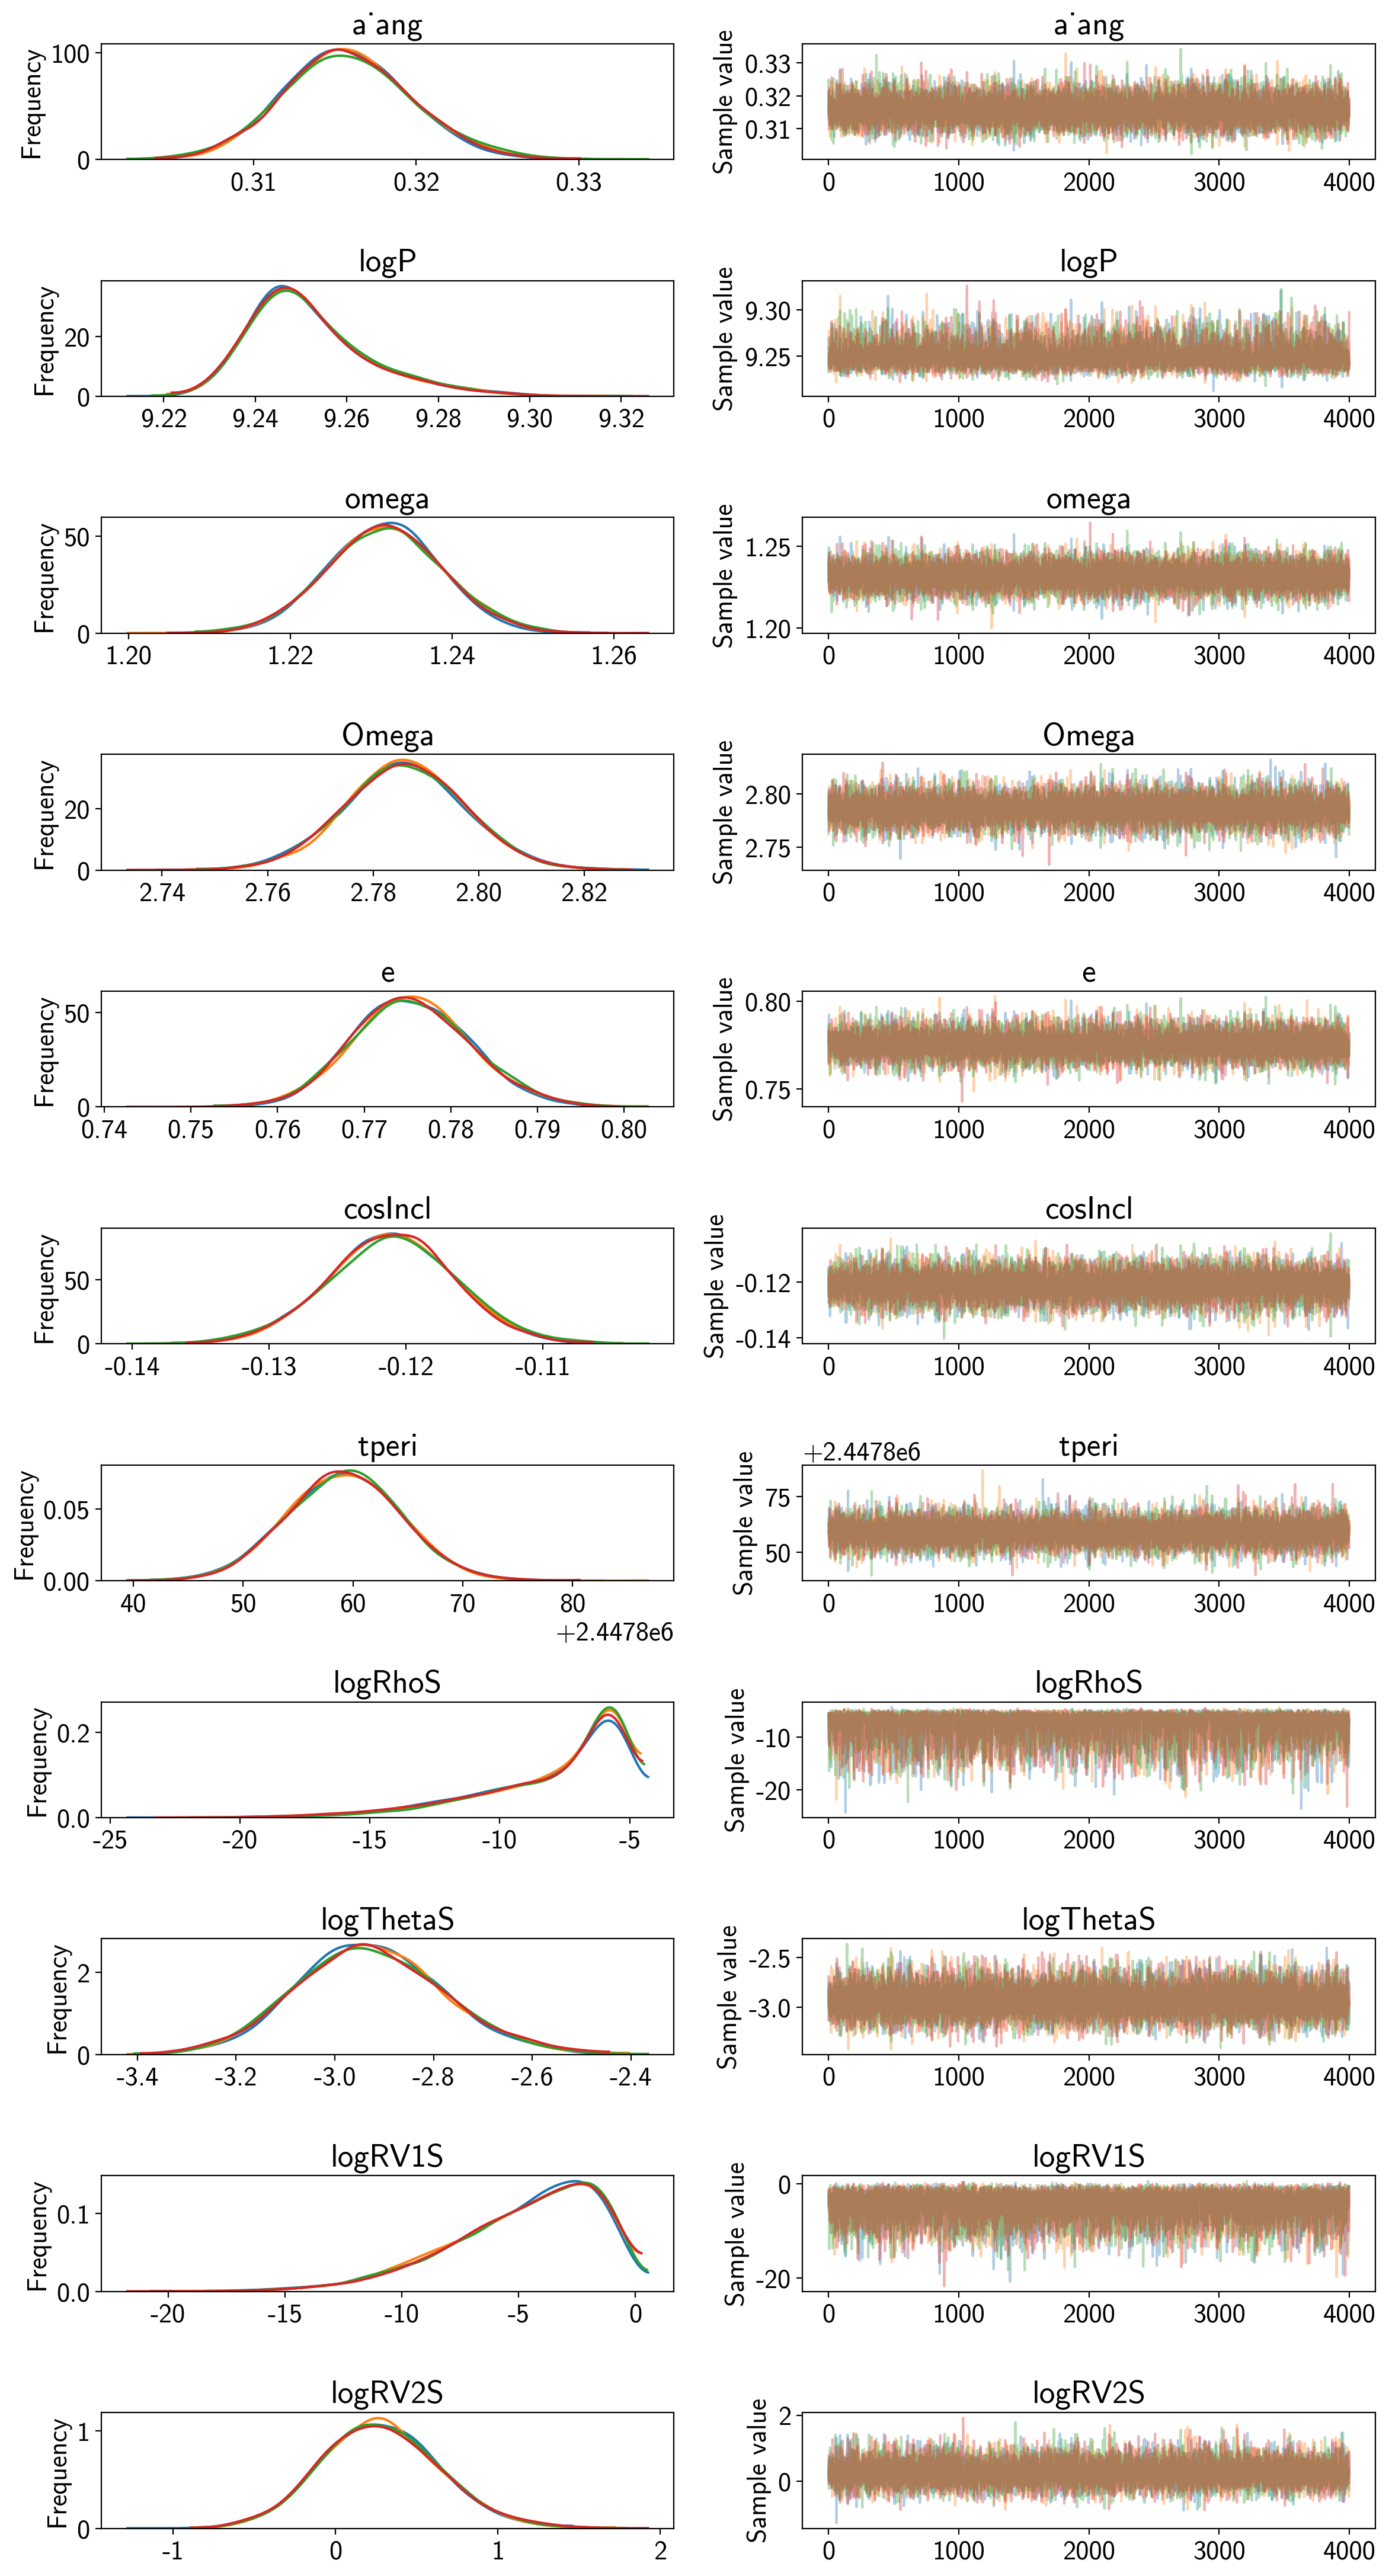

In [16]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

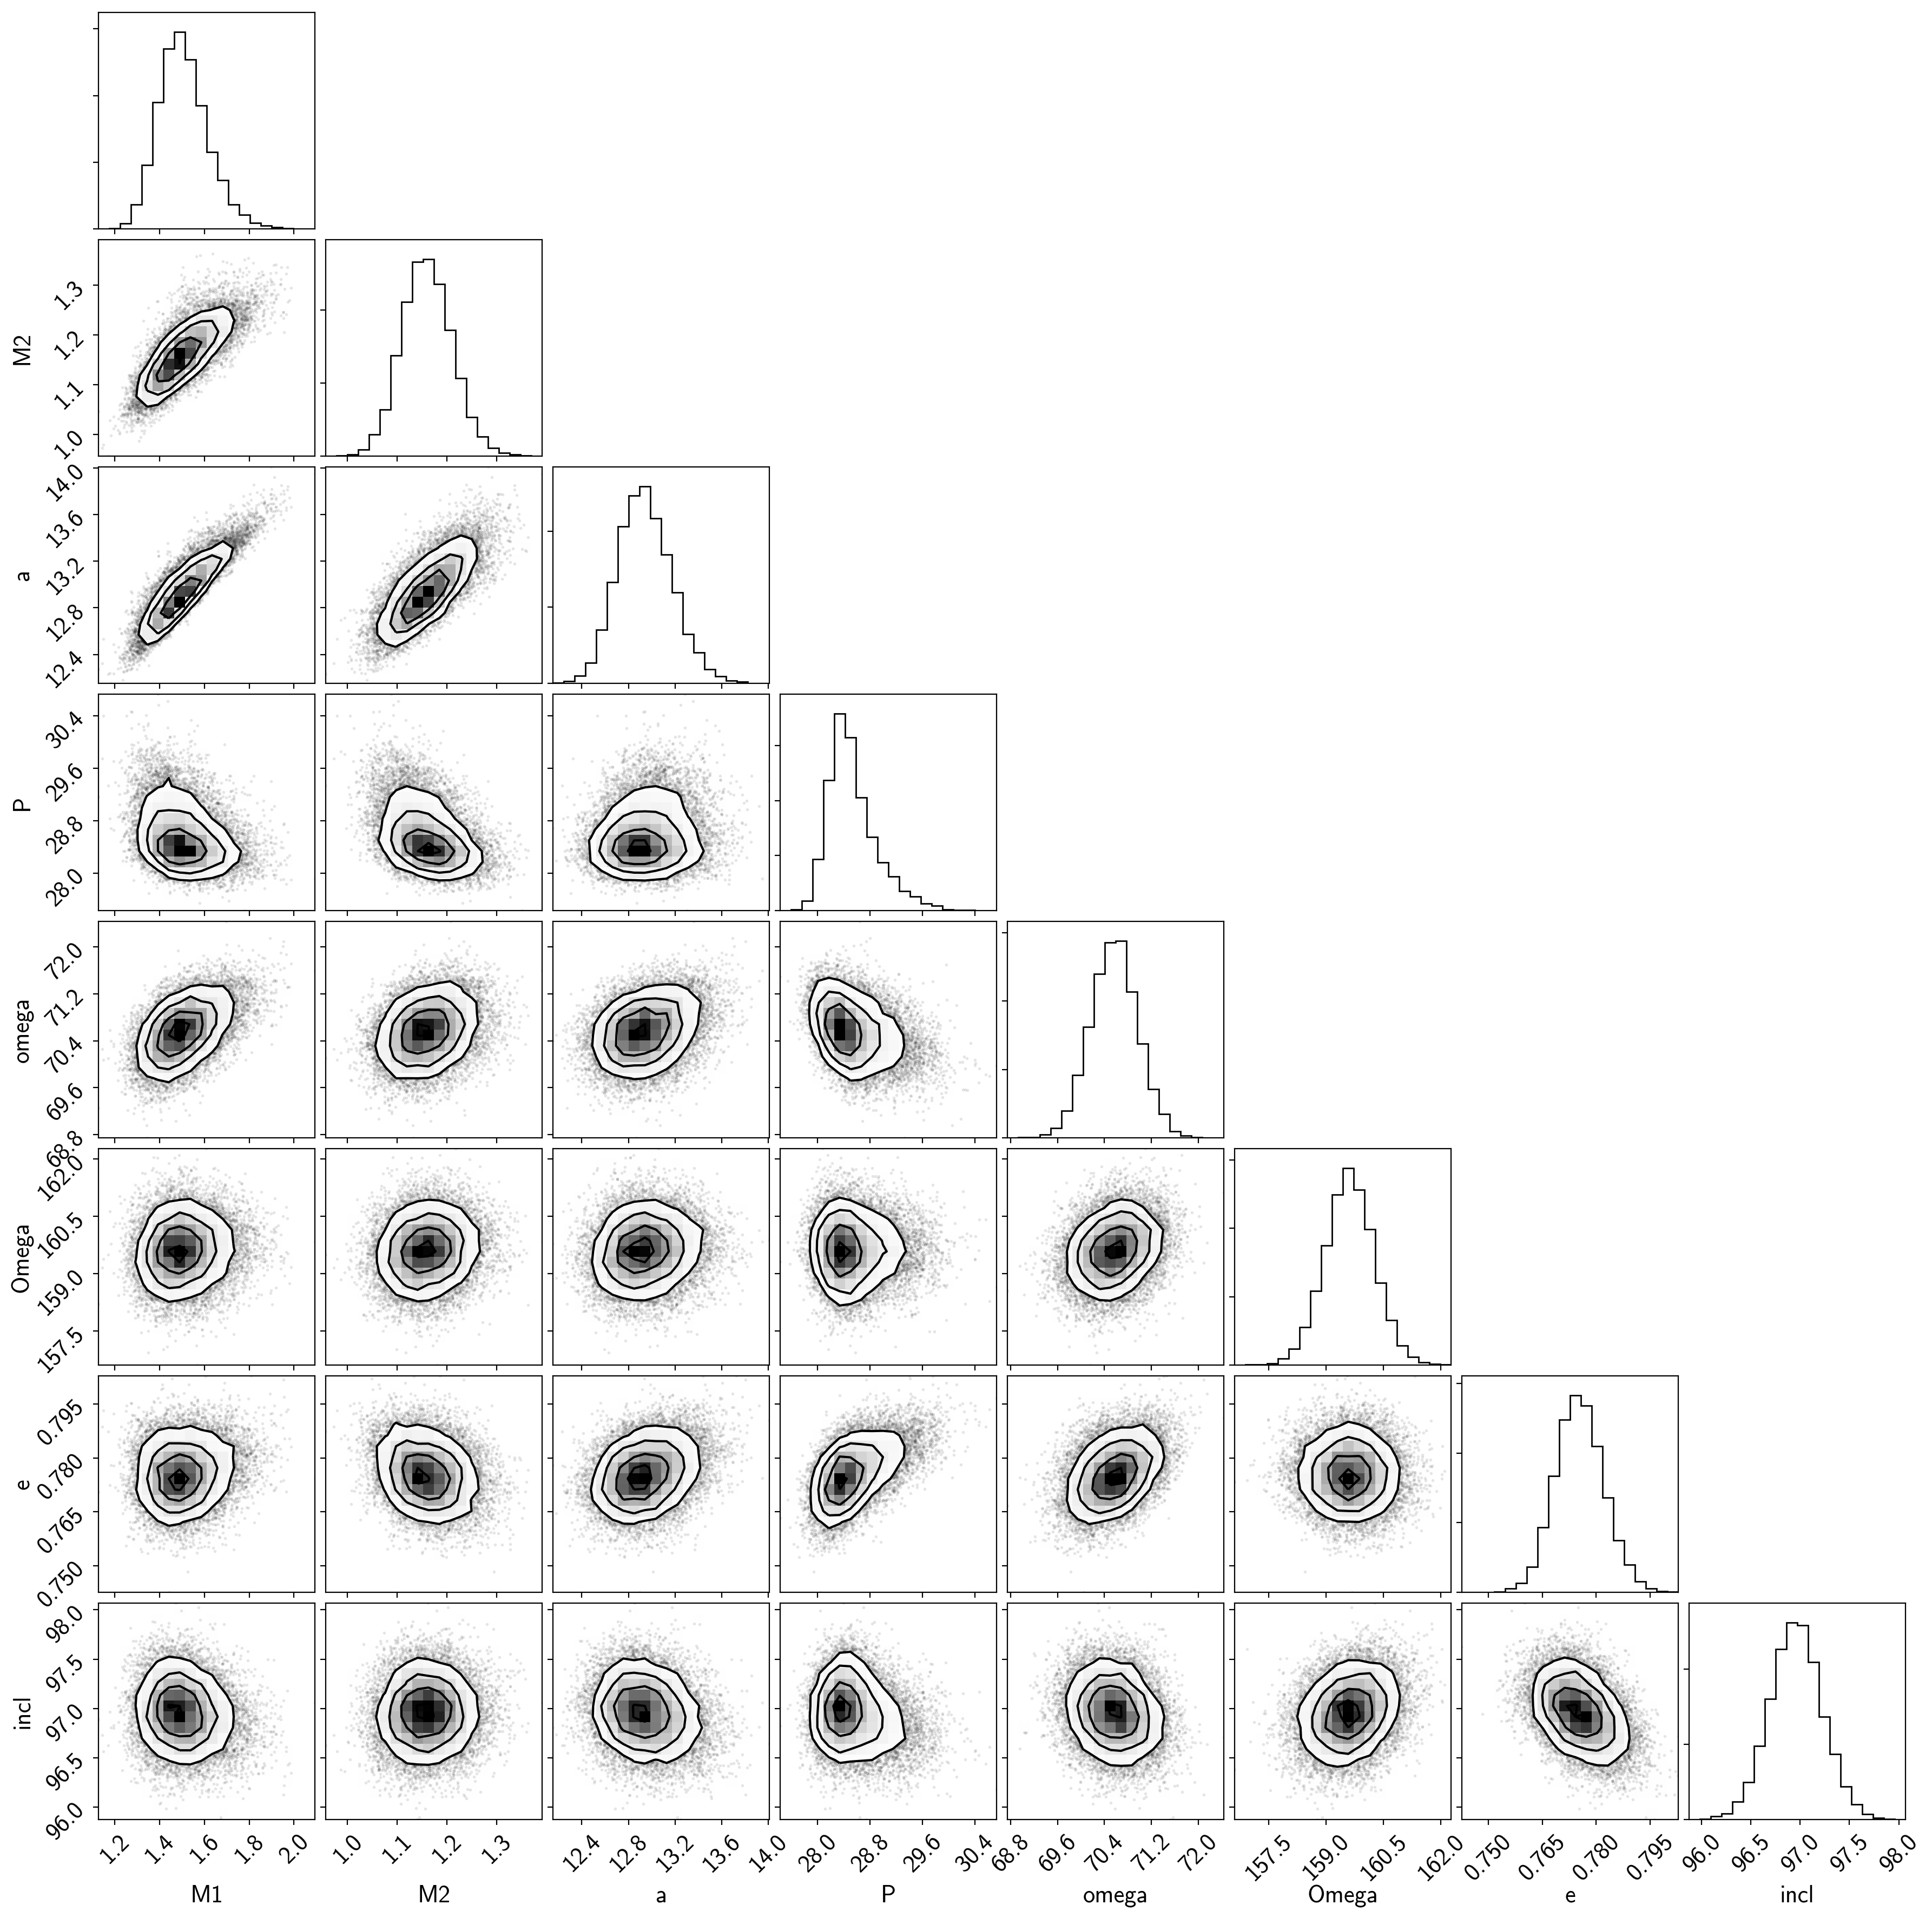

In [17]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["M1", "M2", "a", "P", "omega", "Omega", "e", "incl"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

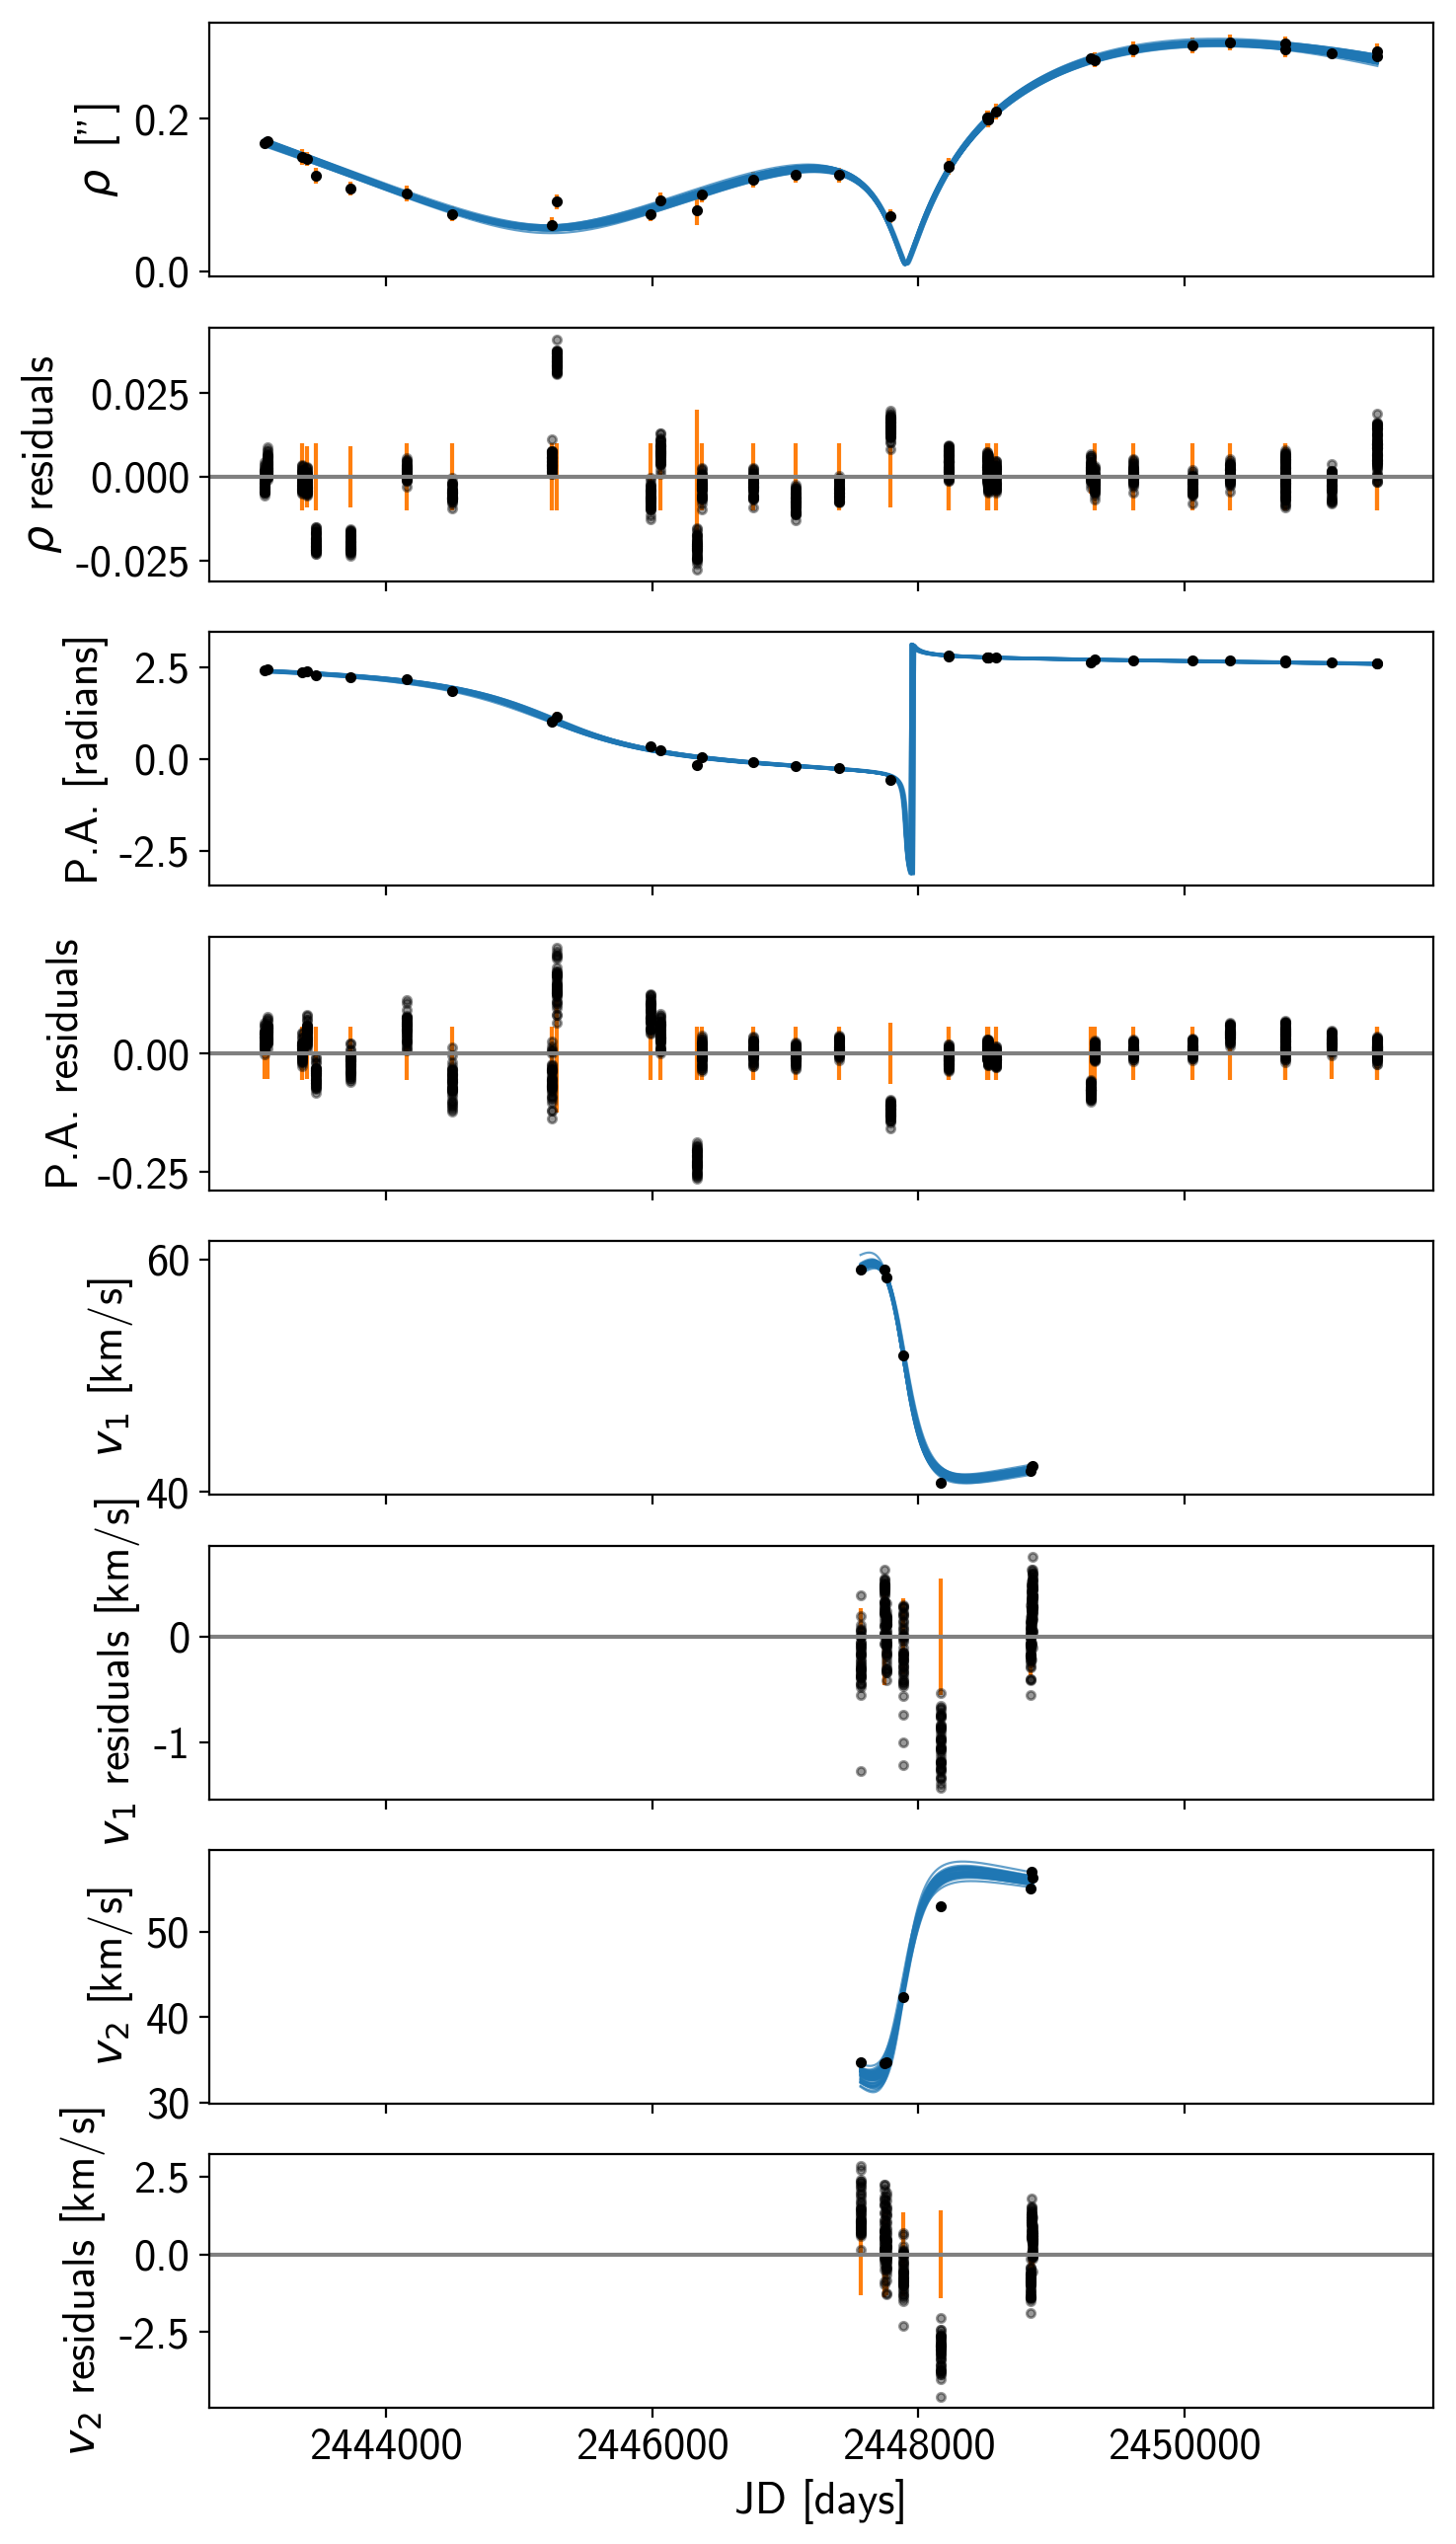

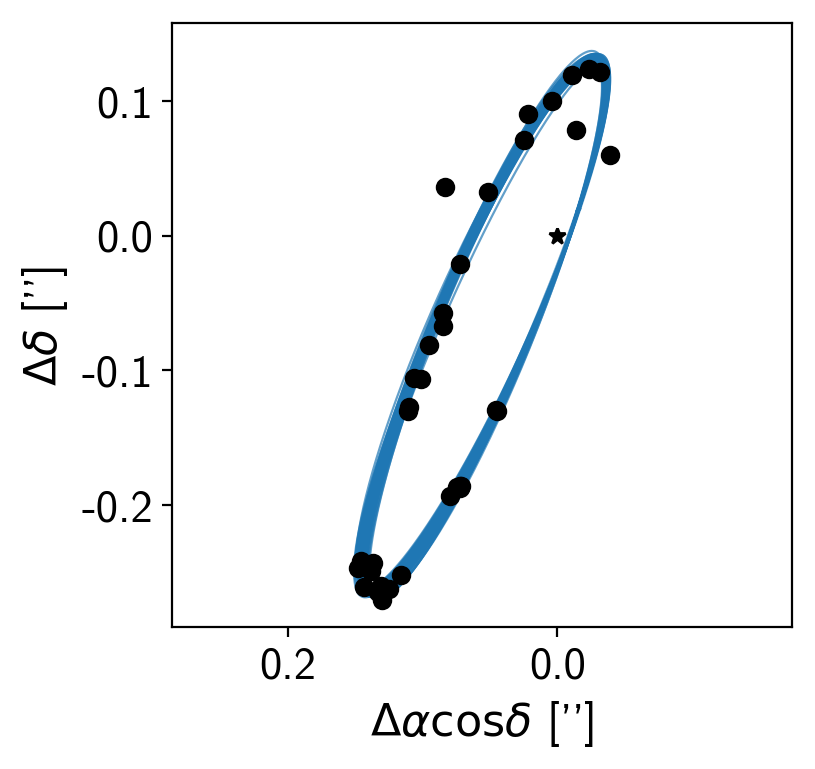

In [18]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(8,16))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)


xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")